In [1]:
# %matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)

import torch # not used

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
from IPython.display import display, clear_output, update_display, HTML

import io
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


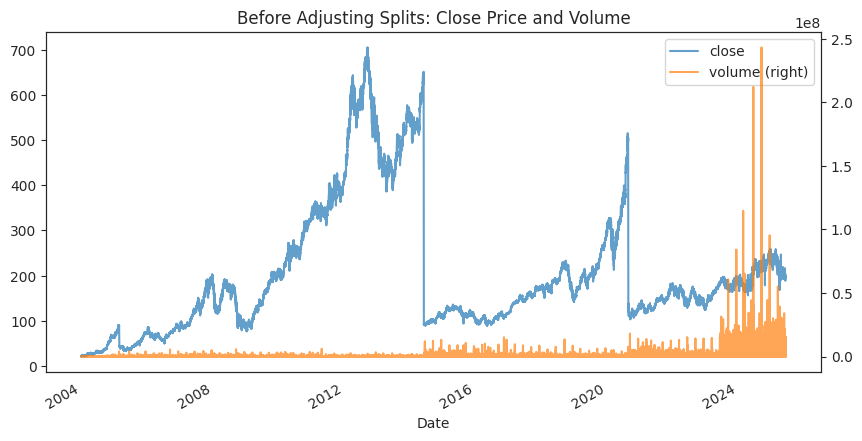

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


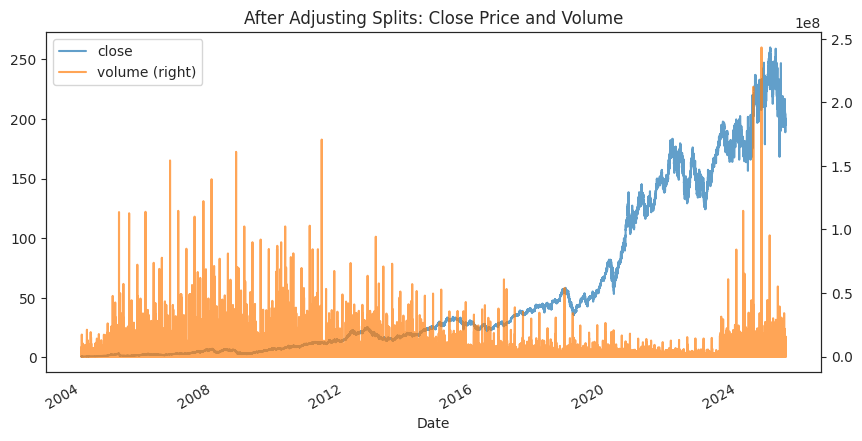

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.962600,196.667400
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.822500,196.527500
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.817500,196.522500
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.387200,196.092800


In [3]:
n_trials = 500
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder              = params.stocks_folder,
    ticker              = params.ticker,
    bidasktoclose_pct   = params.bidasktoclose_pct
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df              = df_raw,
    sess_premark    = params.sess_premark,
    sess_start      = params.sess_start,
    sess_end        = params.sess_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
# importlib.reload(trades) ############################################

def optimization_function(
    df: pd.DataFrame,
    min_prof_thr: float,
    max_down_prop: float,
    gain_tightening_factor: float,
    merging_retracement_thr: float,
    merging_time_gap_thr: float,
    tau_time: int,
    tau_dur: int,
    trailing_stop_pct: float,
    buy_threshold: float,
    smoothing_window: int
) -> float:
    """
    1) Run the full backtest pipeline to simulate trades and P&L per day.
    2) Extract each day’s performance stats (strategy return and trade returns).
    3) Free intermediate DataFrames and trade lists to minimize memory usage.
    4) Compute total and average daily P&L across all trading days.
    5) Compute total trades and average return per trade.
    6) Print a summary of P&L metrics.
    Returns the average daily P&L for Optuna’s objective.
    """
    # A) Execute the end-to-end trading simulation
    simulation = trades.run_trading_pipeline(
        df, 
        col_signal="signal",
        col_action="signal_action",
        min_prof_thr=min_prof_thr,
        max_down_prop=max_down_prop,
        gain_tightening_factor=gain_tightening_factor,
        merging_retracement_thr=merging_retracement_thr,
        merging_time_gap_thr=merging_time_gap_thr,
        tau_time=tau_time,
        tau_dur=tau_dur,
        trailing_stop_pct=trailing_stop_pct,
        buy_threshold=buy_threshold,
        smoothing_window=smoothing_window
    )
    
    # If pipeline returned None (no trading days), bail out
    if not simulation:
        return 0.0

    # B) Extract per-day performance stats from simulation output
    per_day_stats = [
        stats 
        for (_, (_, _, stats)) 
        in simulation.items()
    ]

    # C) Release DataFrames and trade lists to free memory
    for (_, (df_sim, trades_list, _)) in simulation.items():
        del df_sim, trades_list
    num_days = len(simulation)
    del simulation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # D) Compute total and average daily P&L
    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days

    # E) Compute trade-level metrics: total trades and avg return per trade
    trades_only_days = [s for s in per_day_stats if s["Trades Returns ($)"]]
    total_trades     = sum(len(s["Trades Returns ($)"]) for s in trades_only_days)
    avg_per_trade    = (total_pnl / total_trades) if total_trades else 0.0

    # F) Print a summary of results
    print(f"→ Total P&L over {num_days} days   : ${total_pnl:.2f}")
    print(f"→ Avg daily P&L                    : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                     : {total_trades}")
    print(f"→ Avg return per trade            : ${avg_per_trade:.4f}\n")

    return avg_daily_pnl


In [5]:
def objective(trial):
    hyperpars = {
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.02, 0.2), # increasing min, to avoid creating too many trades
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 1.5),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 1, 25),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 1.5),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 0.5, 8.5),
        "tau_time"                : trial.suggest_int("tau_time", 1, 120),
        "tau_dur"                 : trial.suggest_int("tau_dur", 1, 240),
        "trailing_stop_pct"       : trial.suggest_float("trailing_stop_pct", 0.03, 0.15), # increasing min, to reproduce a realistic scenario of trailing stop loss
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.05, 0.85),
        "smoothing_window"        : trial.suggest_categorical("smoothing_window", [3])
    }

    print('---------------------------------------------------------------------------------------------------------------\n')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[I 2025-09-07 22:58:56,184] A new study created in RDB with name: no-name-28e489ce-d913-4f10-b228-9cb0bf720a35


---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 12.391 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.19day/s]
[I 2025-09-07 23:01:45,133] Trial 0 finished with value: 0.3240553703703704 and parameters: {'min_prof_thr': 0.16307062275627932, 'max_down_prop': 0.9373101795252857, 'gain_tightening_factor': 12.726237988937534, 'merging_retracement_thr': 1.2475081546583717, 'merging_time_gap_thr': 0.5199764661631052, 'tau_time': 95, 'tau_dur': 141, 'trailing_stop_pct': 0.07335150769097819, 'buy_threshold': 0.07628320842339127, 'smoothing_window': 3}. Best is trial 0 with value: 0.3240553703703704.


→ Total P&L over 5400 days   : $1749.90
→ Avg daily P&L                    : $0.3241
→ Total trades                     : 20502
→ Avg return per trade            : $0.0854



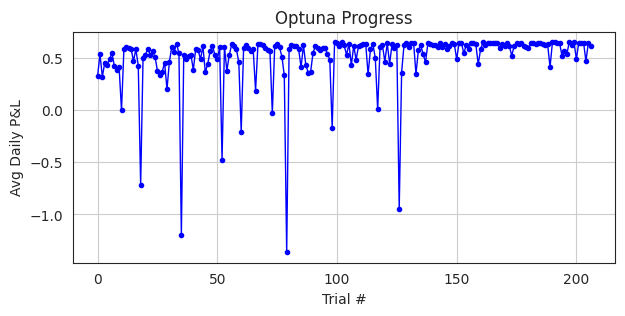

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 8.062 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:23<00:00, 37.71day/s]
[I 2025-09-07 23:04:29,956] Trial 1 finished with value: 0.5336938888888888 and parameters: {'min_prof_thr': 0.0724835075061882, 'max_down_prop': 0.16507685110799036, 'gain_tightening_factor': 6.36035199280568, 'merging_retracement_thr': 0.8044659592329572, 'merging_time_gap_thr': 1.4613139826678818, 'tau_time': 46, 'tau_dur': 216, 'trailing_stop_pct': 0.06404698445285957, 'buy_threshold': 0.24460384988594736, 'smoothing_window': 3}. Best is trial 1 with value: 0.5336938888888888.


→ Total P&L over 5400 days   : $2881.95
→ Avg daily P&L                    : $0.5337
→ Total trades                     : 22740
→ Avg return per trade            : $0.1267

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 10.276 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.29day/s]
[I 2025-09-07 23:07:24,528] Trial 2 finished with value: 0.3215051851851852 and parameters: {'min_prof_thr': 0.13984963556736008, 'max_down_prop': 1.2826880773687666, 'gain_tightening_factor': 17.051403970771613, 'merging_retracement_thr': 0.459039895813655, 'merging_time_gap_thr': 2.495443289150269, 'tau_time': 96, 'tau_dur': 12, 'trailing_stop_pct': 0.06826917815485181, 'buy_threshold': 0.16991029380214684, 'smoothing_window': 3}. Best is trial 1 with value: 0.5336938888888888.


→ Total P&L over 5400 days   : $1736.13
→ Avg daily P&L                    : $0.3215
→ Total trades                     : 25833
→ Avg return per trade            : $0.0672

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 17.247 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.52day/s]
[I 2025-09-07 23:10:21,927] Trial 3 finished with value: 0.45171351851851854 and parameters: {'min_prof_thr': 0.17875866291214249, 'max_down_prop': 0.7757450787293904, 'gain_tightening_factor': 24.73311768200517, 'merging_retracement_thr': 1.4142153912140525, 'merging_time_gap_thr': 5.537395300988018, 'tau_time': 44, 'tau_dur': 140, 'trailing_stop_pct': 0.11315691262853717, 'buy_threshold': 0.6744423283695182, 'smoothing_window': 3}. Best is trial 1 with value: 0.5336938888888888.


→ Total P&L over 5400 days   : $2439.25
→ Avg daily P&L                    : $0.4517
→ Total trades                     : 13540
→ Avg return per trade            : $0.1802

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 10.737 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.61day/s]
[I 2025-09-07 23:13:24,632] Trial 4 finished with value: 0.42955944444444444 and parameters: {'min_prof_thr': 0.14644633429838827, 'max_down_prop': 1.0395423070032346, 'gain_tightening_factor': 12.47520131961829, 'merging_retracement_thr': 0.33846556158666147, 'merging_time_gap_thr': 7.437121912459693, 'tau_time': 46, 'tau_dur': 106, 'trailing_stop_pct': 0.05675958746305136, 'buy_threshold': 0.15871520359163388, 'smoothing_window': 3}. Best is trial 1 with value: 0.5336938888888888.


→ Total P&L over 5400 days   : $2319.62
→ Avg daily P&L                    : $0.4296
→ Total trades                     : 28057
→ Avg return per trade            : $0.0827

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 7.043 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.94day/s]
[I 2025-09-07 23:16:27,487] Trial 5 finished with value: 0.489505925925926 and parameters: {'min_prof_thr': 0.05612218779772747, 'max_down_prop': 0.12091510089779184, 'gain_tightening_factor': 1.47366971228813, 'merging_retracement_thr': 0.3377163276644768, 'merging_time_gap_thr': 3.5816697682736027, 'tau_time': 8, 'tau_dur': 23, 'trailing_stop_pct': 0.06574315149165616, 'buy_threshold': 0.7604716100906396, 'smoothing_window': 3}. Best is trial 1 with value: 0.5336938888888888.


→ Total P&L over 5400 days   : $2643.33
→ Avg daily P&L                    : $0.4895
→ Total trades                     : 31973
→ Avg return per trade            : $0.0827

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.711 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 33.11day/s]
[I 2025-09-07 23:19:31,710] Trial 6 finished with value: 0.5467168518518519 and parameters: {'min_prof_thr': 0.07150177632612861, 'max_down_prop': 0.8041694199064315, 'gain_tightening_factor': 2.677789328993607, 'merging_retracement_thr': 1.3778686592487634, 'merging_time_gap_thr': 7.494029767304297, 'tau_time': 32, 'tau_dur': 150, 'trailing_stop_pct': 0.03936322998583813, 'buy_threshold': 0.20614441890058532, 'smoothing_window': 3}. Best is trial 6 with value: 0.5467168518518519.


→ Total P&L over 5400 days   : $2952.27
→ Avg daily P&L                    : $0.5467
→ Total trades                     : 29104
→ Avg return per trade            : $0.1014

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.162 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.62day/s]
[I 2025-09-07 23:22:42,736] Trial 7 finished with value: 0.42361092592592586 and parameters: {'min_prof_thr': 0.04819115140362573, 'max_down_prop': 1.1277456044924743, 'gain_tightening_factor': 18.03162005753118, 'merging_retracement_thr': 1.4769314196836163, 'merging_time_gap_thr': 7.317773306156873, 'tau_time': 83, 'tau_dur': 199, 'trailing_stop_pct': 0.1164108024892672, 'buy_threshold': 0.14893680593693492, 'smoothing_window': 3}. Best is trial 6 with value: 0.5467168518518519.


→ Total P&L over 5400 days   : $2287.50
→ Avg daily P&L                    : $0.4236
→ Total trades                     : 19159
→ Avg return per trade            : $0.1194

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 18.475 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.42day/s]
[I 2025-09-07 23:25:43,564] Trial 8 finished with value: 0.3853979629629629 and parameters: {'min_prof_thr': 0.179906805620723, 'max_down_prop': 0.33563905200515654, 'gain_tightening_factor': 9.72122321471264, 'merging_retracement_thr': 0.8795102502221782, 'merging_time_gap_thr': 5.66913310653537, 'tau_time': 112, 'tau_dur': 71, 'trailing_stop_pct': 0.08124467254988552, 'buy_threshold': 0.20359294149375246, 'smoothing_window': 3}. Best is trial 6 with value: 0.5467168518518519.


→ Total P&L over 5400 days   : $2081.15
→ Avg daily P&L                    : $0.3854
→ Total trades                     : 14920
→ Avg return per trade            : $0.1395

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 10.91 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:24<00:00, 37.49day/s]
[I 2025-09-07 23:28:23,441] Trial 9 finished with value: 0.4114464814814815 and parameters: {'min_prof_thr': 0.1299745860771909, 'max_down_prop': 0.736022887216716, 'gain_tightening_factor': 14.74791106319066, 'merging_retracement_thr': 1.2743156238154767, 'merging_time_gap_thr': 4.5926971558065075, 'tau_time': 106, 'tau_dur': 23, 'trailing_stop_pct': 0.05487947442713996, 'buy_threshold': 0.5361599896286651, 'smoothing_window': 3}. Best is trial 6 with value: 0.5467168518518519.


→ Total P&L over 5400 days   : $2221.81
→ Avg daily P&L                    : $0.4114
→ Total trades                     : 19675
→ Avg return per trade            : $0.1129

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 7.814 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:23<00:00, 37.61day/s]
[I 2025-09-07 23:31:03,808] Trial 10 finished with value: -0.0037414814814814854 and parameters: {'min_prof_thr': 0.09408009954691378, 'max_down_prop': 0.5234719372448836, 'gain_tightening_factor': 1.716598888796355, 'merging_retracement_thr': 1.0380186754934992, 'merging_time_gap_thr': 8.083380577101018, 'tau_time': 5, 'tau_dur': 180, 'trailing_stop_pct': 0.1399025479171752, 'buy_threshold': 0.38641783738982666, 'smoothing_window': 3}. Best is trial 6 with value: 0.5467168518518519.


→ Total P&L over 5400 days   : $-20.20
→ Avg daily P&L                    : $-0.0037
→ Total trades                     : 39955
→ Avg return per trade            : $-0.0005

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 7.822 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:21<00:00, 38.29day/s]
[I 2025-09-07 23:33:43,185] Trial 11 finished with value: 0.5808081481481482 and parameters: {'min_prof_thr': 0.08457230354439169, 'max_down_prop': 0.5392417267566, 'gain_tightening_factor': 6.550928790755134, 'merging_retracement_thr': 0.6960222252408167, 'merging_time_gap_thr': 0.6357082449870987, 'tau_time': 31, 'tau_dur': 240, 'trailing_stop_pct': 0.030049728874650808, 'buy_threshold': 0.33396670280451346, 'smoothing_window': 3}. Best is trial 11 with value: 0.5808081481481482.


→ Total P&L over 5400 days   : $3136.36
→ Avg daily P&L                    : $0.5808
→ Total trades                     : 24886
→ Avg return per trade            : $0.1260

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.498 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.33day/s]
[I 2025-09-07 23:36:27,757] Trial 12 finished with value: 0.6063725925925926 and parameters: {'min_prof_thr': 0.020832637779312824, 'max_down_prop': 0.5578823502955248, 'gain_tightening_factor': 6.106005976946264, 'merging_retracement_thr': 0.5579946054583252, 'merging_time_gap_thr': 3.072143216484055, 'tau_time': 22, 'tau_dur': 237, 'trailing_stop_pct': 0.03069034482888338, 'buy_threshold': 0.36446235302931157, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $3274.41
→ Avg daily P&L                    : $0.6064
→ Total trades                     : 29159
→ Avg return per trade            : $0.1123

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.549 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.49day/s]
[I 2025-09-07 23:39:12,078] Trial 13 finished with value: 0.5919687037037038 and parameters: {'min_prof_thr': 0.022694876215999436, 'max_down_prop': 0.513544287205287, 'gain_tightening_factor': 6.981210327530787, 'merging_retracement_thr': 0.5870236432298375, 'merging_time_gap_thr': 2.4270773343656757, 'tau_time': 23, 'tau_dur': 240, 'trailing_stop_pct': 0.03413931163050705, 'buy_threshold': 0.39293145881579417, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $3196.63
→ Avg daily P&L                    : $0.5920
→ Total trades                     : 27016
→ Avg return per trade            : $0.1183

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.588 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.22day/s]
[I 2025-09-07 23:41:54,078] Trial 14 finished with value: 0.5878153703703705 and parameters: {'min_prof_thr': 0.02392566505551855, 'max_down_prop': 0.4805508401571256, 'gain_tightening_factor': 6.706781932450473, 'merging_retracement_thr': 0.5790838641076901, 'merging_time_gap_thr': 2.7591362081551454, 'tau_time': 19, 'tau_dur': 238, 'trailing_stop_pct': 0.04135236233828535, 'buy_threshold': 0.5185813758337046, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $3174.20
→ Avg daily P&L                    : $0.5878
→ Total trades                     : 23253
→ Avg return per trade            : $0.1365

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.479 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.57day/s]
[I 2025-09-07 23:44:30,998] Trial 15 finished with value: 0.4704298148148148 and parameters: {'min_prof_thr': 0.023938170472973495, 'max_down_prop': 1.486765043808072, 'gain_tightening_factor': 8.007232056416443, 'merging_retracement_thr': 0.5734397021173416, 'merging_time_gap_thr': 2.524373121837774, 'tau_time': 64, 'tau_dur': 187, 'trailing_stop_pct': 0.0942024968475002, 'buy_threshold': 0.4845060459578733, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $2540.32
→ Avg daily P&L                    : $0.4704
→ Total trades                     : 12982
→ Avg return per trade            : $0.1957

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.957 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.24day/s]
[I 2025-09-07 23:47:11,144] Trial 16 finished with value: 0.5819538888888889 and parameters: {'min_prof_thr': 0.040927286720019516, 'max_down_prop': 0.6363645056808556, 'gain_tightening_factor': 4.121158786376833, 'merging_retracement_thr': 0.1316488438622836, 'merging_time_gap_thr': 3.911217079480611, 'tau_time': 26, 'tau_dur': 215, 'trailing_stop_pct': 0.04611525934960583, 'buy_threshold': 0.3445279158221873, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $3142.55
→ Avg daily P&L                    : $0.5820
→ Total trades                     : 31097
→ Avg return per trade            : $0.1011

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 10.326 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.29day/s]
[I 2025-09-07 23:49:44,552] Trial 17 finished with value: 0.42697777777777773 and parameters: {'min_prof_thr': 0.10680276439899387, 'max_down_prop': 0.3305193080040948, 'gain_tightening_factor': 10.21439918496358, 'merging_retracement_thr': 0.9554106984465576, 'merging_time_gap_thr': 1.6609139936981845, 'tau_time': 63, 'tau_dur': 168, 'trailing_stop_pct': 0.030434980266218176, 'buy_threshold': 0.5997651632528473, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $2305.68
→ Avg daily P&L                    : $0.4270
→ Total trades                     : 16428
→ Avg return per trade            : $0.1404

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.584 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.92day/s]
[I 2025-09-07 23:52:29,677] Trial 18 finished with value: -0.7183851851851851 and parameters: {'min_prof_thr': 0.022852746789603848, 'max_down_prop': 0.3397887224186189, 'gain_tightening_factor': 3.892747192788257, 'merging_retracement_thr': 0.14814292999854928, 'merging_time_gap_thr': 4.891505185647945, 'tau_time': 1, 'tau_dur': 102, 'trailing_stop_pct': 0.09310168902596697, 'buy_threshold': 0.40580872465599577, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $-3879.28
→ Avg daily P&L                    : $-0.7184
→ Total trades                     : 101782
→ Avg return per trade            : $-0.0381

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.123 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.01day/s]
[I 2025-09-07 23:55:10,409] Trial 19 finished with value: 0.5027375925925925 and parameters: {'min_prof_thr': 0.04388049136427262, 'max_down_prop': 0.6247963846895754, 'gain_tightening_factor': 9.791665289802332, 'merging_retracement_thr': 0.6735955015961075, 'merging_time_gap_thr': 3.737577602445274, 'tau_time': 16, 'tau_dur': 212, 'trailing_stop_pct': 0.1480195734770274, 'buy_threshold': 0.29980723995981656, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $2714.78
→ Avg daily P&L                    : $0.5027
→ Total trades                     : 30439
→ Avg return per trade            : $0.0892

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.913 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.21day/s]
[I 2025-09-07 23:57:47,805] Trial 20 finished with value: 0.531269074074074 and parameters: {'min_prof_thr': 0.06390293430538235, 'max_down_prop': 0.8949199357312534, 'gain_tightening_factor': 22.094133674631024, 'merging_retracement_thr': 0.3590439136856533, 'merging_time_gap_thr': 1.6981767607827942, 'tau_time': 39, 'tau_dur': 61, 'trailing_stop_pct': 0.04774544233774575, 'buy_threshold': 0.45534547225272093, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $2868.85
→ Avg daily P&L                    : $0.5313
→ Total trades                     : 20718
→ Avg return per trade            : $0.1385

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.613 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.33day/s]
[I 2025-09-08 00:00:26,943] Trial 21 finished with value: 0.5846618518518518 and parameters: {'min_prof_thr': 0.025092819095329615, 'max_down_prop': 0.4448000456110686, 'gain_tightening_factor': 5.343439195638824, 'merging_retracement_thr': 0.5215434592616854, 'merging_time_gap_thr': 2.793712962741689, 'tau_time': 17, 'tau_dur': 216, 'trailing_stop_pct': 0.038771660100302044, 'buy_threshold': 0.5519039340516992, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $3157.17
→ Avg daily P&L                    : $0.5847
→ Total trades                     : 23288
→ Avg return per trade            : $0.1356

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.909 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:21<00:00, 38.16day/s]
[I 2025-09-08 00:03:09,197] Trial 22 finished with value: 0.5326577777777778 and parameters: {'min_prof_thr': 0.034307860055112445, 'max_down_prop': 0.4254447265486385, 'gain_tightening_factor': 7.998336571234434, 'merging_retracement_thr': 0.6576321945293322, 'merging_time_gap_thr': 3.051460107227123, 'tau_time': 17, 'tau_dur': 239, 'trailing_stop_pct': 0.04287364456645415, 'buy_threshold': 0.6620490460677368, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $2876.35
→ Avg daily P&L                    : $0.5327
→ Total trades                     : 19596
→ Avg return per trade            : $0.1468

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.51 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.70day/s]
[I 2025-09-08 00:05:47,742] Trial 23 finished with value: 0.5626453703703704 and parameters: {'min_prof_thr': 0.02150813122917279, 'max_down_prop': 0.6410142197331921, 'gain_tightening_factor': 7.786963061795918, 'merging_retracement_thr': 0.4424068758021213, 'merging_time_gap_thr': 3.3681126807200172, 'tau_time': 22, 'tau_dur': 240, 'trailing_stop_pct': 0.03076183464752303, 'buy_threshold': 0.49207717734313716, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $3038.29
→ Avg daily P&L                    : $0.5626
→ Total trades                     : 22629
→ Avg return per trade            : $0.1343

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.463 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.89day/s]
[I 2025-09-08 00:08:26,119] Trial 24 finished with value: 0.5104159259259259 and parameters: {'min_prof_thr': 0.04845373312988692, 'max_down_prop': 0.2937411906235055, 'gain_tightening_factor': 4.555233141066419, 'merging_retracement_thr': 0.7742409534443746, 'merging_time_gap_thr': 1.9321685007592215, 'tau_time': 52, 'tau_dur': 201, 'trailing_stop_pct': 0.05419940100415037, 'buy_threshold': 0.4097053109000752, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $2756.25
→ Avg daily P&L                    : $0.5104
→ Total trades                     : 19203
→ Avg return per trade            : $0.1435

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.128 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.10day/s]
[I 2025-09-08 00:11:03,971] Trial 25 finished with value: 0.37926759259259263 and parameters: {'min_prof_thr': 0.03643367663016335, 'max_down_prop': 0.2179984660974572, 'gain_tightening_factor': 11.127308901833878, 'merging_retracement_thr': 0.23523134536802337, 'merging_time_gap_thr': 4.1813019819938475, 'tau_time': 35, 'tau_dur': 166, 'trailing_stop_pct': 0.08165219054060555, 'buy_threshold': 0.8323545909845318, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $2048.05
→ Avg daily P&L                    : $0.3793
→ Total trades                     : 9331
→ Avg return per trade            : $0.2195

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 17.924 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:21<00:00, 38.24day/s]
[I 2025-09-08 00:13:39,914] Trial 26 finished with value: 0.33367981481481485 and parameters: {'min_prof_thr': 0.19750724662838948, 'max_down_prop': 0.45386598350174434, 'gain_tightening_factor': 6.541483244238547, 'merging_retracement_thr': 0.584752466032622, 'merging_time_gap_thr': 2.2118675366705345, 'tau_time': 11, 'tau_dur': 225, 'trailing_stop_pct': 0.03767183299063797, 'buy_threshold': 0.30399047653147837, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $1801.87
→ Avg daily P&L                    : $0.3337
→ Total trades                     : 34171
→ Avg return per trade            : $0.0527

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.812 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.26day/s]
[I 2025-09-08 00:16:13,049] Trial 27 finished with value: 0.3676464814814815 and parameters: {'min_prof_thr': 0.05876032662883799, 'max_down_prop': 0.5540822272212796, 'gain_tightening_factor': 13.961362244556437, 'merging_retracement_thr': 0.45922377610193743, 'merging_time_gap_thr': 1.1192896496090015, 'tau_time': 72, 'tau_dur': 200, 'trailing_stop_pct': 0.04983962216042047, 'buy_threshold': 0.6223694634146456, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $1985.29
→ Avg daily P&L                    : $0.3676
→ Total trades                     : 11285
→ Avg return per trade            : $0.1759

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 7.146 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.81day/s]
[I 2025-09-08 00:18:47,387] Trial 28 finished with value: 0.45368777777777775 and parameters: {'min_prof_thr': 0.08181094874061738, 'max_down_prop': 0.6953435554874712, 'gain_tightening_factor': 2.985502967274139, 'merging_retracement_thr': 1.0463484488235062, 'merging_time_gap_thr': 3.052202707496883, 'tau_time': 55, 'tau_dur': 227, 'trailing_stop_pct': 0.05949874806380324, 'buy_threshold': 0.5474423254373214, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $2449.91
→ Avg daily P&L                    : $0.4537
→ Total trades                     : 14862
→ Avg return per trade            : $0.1648

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.802 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.03day/s]
[I 2025-09-08 00:21:29,296] Trial 29 finished with value: 0.19898055555555552 and parameters: {'min_prof_thr': 0.034395831281918456, 'max_down_prop': 0.9130323377293277, 'gain_tightening_factor': 12.219397792990712, 'merging_retracement_thr': 0.7396147608125685, 'merging_time_gap_thr': 5.3212117958393, 'tau_time': 23, 'tau_dur': 185, 'trailing_stop_pct': 0.07544570530417896, 'buy_threshold': 0.05872010386989124, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $1074.49
→ Avg daily P&L                    : $0.1990
→ Total trades                     : 37883
→ Avg return per trade            : $0.0284

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 8.793 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.57day/s]
[I 2025-09-08 00:24:00,504] Trial 30 finished with value: 0.46211 and parameters: {'min_prof_thr': 0.11589497071255411, 'max_down_prop': 0.8457024627413521, 'gain_tightening_factor': 7.84167760587854, 'merging_retracement_thr': 0.255282964995941, 'merging_time_gap_thr': 6.302063484694209, 'tau_time': 75, 'tau_dur': 141, 'trailing_stop_pct': 0.10366836418949006, 'buy_threshold': 0.4307312439594282, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $2495.39
→ Avg daily P&L                    : $0.4621
→ Total trades                     : 13754
→ Avg return per trade            : $0.1814

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.674 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.37day/s]
[I 2025-09-08 00:26:39,819] Trial 31 finished with value: 0.6051483333333334 and parameters: {'min_prof_thr': 0.027518147411713392, 'max_down_prop': 0.4932673683091736, 'gain_tightening_factor': 5.979690548808941, 'merging_retracement_thr': 0.5548547644204889, 'merging_time_gap_thr': 2.8041933901797194, 'tau_time': 15, 'tau_dur': 227, 'trailing_stop_pct': 0.04383061434767487, 'buy_threshold': 0.5300960133933682, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $3267.80
→ Avg daily P&L                    : $0.6051
→ Total trades                     : 25481
→ Avg return per trade            : $0.1282

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.811 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.66day/s]
[I 2025-09-08 00:29:17,972] Trial 32 finished with value: 0.5578859259259258 and parameters: {'min_prof_thr': 0.03152156453136927, 'max_down_prop': 0.4322266055259505, 'gain_tightening_factor': 5.876618123696951, 'merging_retracement_thr': 0.5979799841443106, 'merging_time_gap_thr': 1.1354902556035453, 'tau_time': 27, 'tau_dur': 229, 'trailing_stop_pct': 0.0377146104051287, 'buy_threshold': 0.4801081052726548, 'smoothing_window': 3}. Best is trial 12 with value: 0.6063725925925926.


→ Total P&L over 5400 days   : $3012.58
→ Avg daily P&L                    : $0.5579
→ Total trades                     : 21905
→ Avg return per trade            : $0.1375

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.232 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:20<00:00, 38.54day/s]
[I 2025-09-08 00:32:00,227] Trial 33 finished with value: 0.63653 and parameters: {'min_prof_thr': 0.04839415540329786, 'max_down_prop': 0.5631837986368129, 'gain_tightening_factor': 5.103013491047496, 'merging_retracement_thr': 0.5255227498115422, 'merging_time_gap_thr': 2.359293310296886, 'tau_time': 13, 'tau_dur': 207, 'trailing_stop_pct': 0.04606886802678939, 'buy_threshold': 0.3460435110925543, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3437.26
→ Avg daily P&L                    : $0.6365
→ Total trades                     : 36899
→ Avg return per trade            : $0.0932

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.685 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.65day/s]
[I 2025-09-08 00:34:37,423] Trial 34 finished with value: 0.5423122222222222 and parameters: {'min_prof_thr': 0.050083481186908585, 'max_down_prop': 0.2180501357670933, 'gain_tightening_factor': 8.827723038270529, 'merging_retracement_thr': 0.8205680838068321, 'merging_time_gap_thr': 2.253123081639825, 'tau_time': 11, 'tau_dur': 206, 'trailing_stop_pct': 0.06297965909170755, 'buy_threshold': 0.2525088098328858, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2928.49
→ Avg daily P&L                    : $0.5423
→ Total trades                     : 42073
→ Avg return per trade            : $0.0696

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.83 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.02day/s]
[I 2025-09-08 00:37:11,790] Trial 35 finished with value: -1.1961175925925926 and parameters: {'min_prof_thr': 0.06676459043359505, 'max_down_prop': 0.5927921753612986, 'gain_tightening_factor': 4.91328039526929, 'merging_retracement_thr': 0.45398303692269437, 'merging_time_gap_thr': 3.426297719579929, 'tau_time': 1, 'tau_dur': 223, 'trailing_stop_pct': 0.05056591071761187, 'buy_threshold': 0.36691631400733693, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $-6459.03
→ Avg daily P&L                    : $-1.1961
→ Total trades                     : 115726
→ Avg return per trade            : $-0.0558

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.352 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.78day/s]
[I 2025-09-08 00:39:48,010] Trial 36 finished with value: 0.5231927777777777 and parameters: {'min_prof_thr': 0.05636271045396947, 'max_down_prop': 0.6932304164325068, 'gain_tightening_factor': 2.9528957994939136, 'merging_retracement_thr': 0.3852758862513281, 'merging_time_gap_thr': 2.1304812100509567, 'tau_time': 11, 'tau_dur': 191, 'trailing_stop_pct': 0.07091315570376155, 'buy_threshold': 0.2702724292661723, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2825.24
→ Avg daily P&L                    : $0.5232
→ Total trades                     : 45070
→ Avg return per trade            : $0.0627

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.778 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.86day/s]
[I 2025-09-08 00:42:20,673] Trial 37 finished with value: 0.49057333333333336 and parameters: {'min_prof_thr': 0.037803269260563495, 'max_down_prop': 0.9893289299879504, 'gain_tightening_factor': 1.079624037076929, 'merging_retracement_thr': 0.516274416850256, 'merging_time_gap_thr': 1.261242164436239, 'tau_time': 40, 'tau_dur': 171, 'trailing_stop_pct': 0.03457932561081209, 'buy_threshold': 0.3170484404896328, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2649.10
→ Avg daily P&L                    : $0.4906
→ Total trades                     : 20513
→ Avg return per trade            : $0.1291

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 7.331 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.02day/s]
[I 2025-09-08 00:44:53,786] Trial 38 finished with value: 0.5223524074074074 and parameters: {'min_prof_thr': 0.07775981491573164, 'max_down_prop': 0.7648438558741939, 'gain_tightening_factor': 10.976164495071803, 'merging_retracement_thr': 0.2824520551725908, 'merging_time_gap_thr': 0.7363234490177994, 'tau_time': 30, 'tau_dur': 123, 'trailing_stop_pct': 0.04528222865909359, 'buy_threshold': 0.5869022588610097, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2820.70
→ Avg daily P&L                    : $0.5224
→ Total trades                     : 17828
→ Avg return per trade            : $0.1582

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.642 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.84day/s]
[I 2025-09-08 00:47:28,361] Trial 39 finished with value: 0.5304385185185185 and parameters: {'min_prof_thr': 0.05057450661131079, 'max_down_prop': 0.38030731700589404, 'gain_tightening_factor': 17.30216014015612, 'merging_retracement_thr': 0.9007146510193131, 'merging_time_gap_thr': 4.234900947624809, 'tau_time': 50, 'tau_dur': 217, 'trailing_stop_pct': 0.12674099919983578, 'buy_threshold': 0.44913084369946005, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2864.37
→ Avg daily P&L                    : $0.5304
→ Total trades                     : 15244
→ Avg return per trade            : $0.1879

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.875 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.33day/s]
[I 2025-09-08 00:50:12,113] Trial 40 finished with value: 0.38481370370370366 and parameters: {'min_prof_thr': 0.029709695341726693, 'max_down_prop': 0.2644616601078746, 'gain_tightening_factor': 15.330633823306181, 'merging_retracement_thr': 0.6470256838791681, 'merging_time_gap_thr': 3.0537264201035534, 'tau_time': 36, 'tau_dur': 153, 'trailing_stop_pct': 0.06493975990624754, 'buy_threshold': 0.11149419173273262, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2077.99
→ Avg daily P&L                    : $0.3848
→ Total trades                     : 32483
→ Avg return per trade            : $0.0640

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.573 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.52day/s]
[I 2025-09-08 00:52:52,044] Trial 41 finished with value: 0.587963888888889 and parameters: {'min_prof_thr': 0.023626722057104033, 'max_down_prop': 0.5017261602417732, 'gain_tightening_factor': 6.510572487106793, 'merging_retracement_thr': 0.5296439215134163, 'merging_time_gap_thr': 2.6606002646753364, 'tau_time': 20, 'tau_dur': 230, 'trailing_stop_pct': 0.04308276750983722, 'buy_threshold': 0.503639105806716, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3175.01
→ Avg daily P&L                    : $0.5880
→ Total trades                     : 23102
→ Avg return per trade            : $0.1374

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.492 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.68day/s]
[I 2025-09-08 00:55:31,518] Trial 42 finished with value: 0.5757357407407407 and parameters: {'min_prof_thr': 0.020176796608639812, 'max_down_prop': 0.5063123927928672, 'gain_tightening_factor': 5.432750897273858, 'merging_retracement_thr': 0.5085063872235236, 'merging_time_gap_thr': 2.595421638767191, 'tau_time': 8, 'tau_dur': 228, 'trailing_stop_pct': 0.054771213327175876, 'buy_threshold': 0.3727659658932103, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3108.97
→ Avg daily P&L                    : $0.5757
→ Total trades                     : 44585
→ Avg return per trade            : $0.0697

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 17.051 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.26day/s]
[I 2025-09-08 00:58:03,555] Trial 43 finished with value: 0.48727 and parameters: {'min_prof_thr': 0.15247043076714112, 'max_down_prop': 0.11107172888521061, 'gain_tightening_factor': 6.780782895445106, 'merging_retracement_thr': 0.3934624535535031, 'merging_time_gap_thr': 3.248837793198656, 'tau_time': 44, 'tau_dur': 207, 'trailing_stop_pct': 0.03457084191574086, 'buy_threshold': 0.6866439642011636, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2631.26
→ Avg daily P&L                    : $0.4873
→ Total trades                     : 16203
→ Avg return per trade            : $0.1624

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.059 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.58day/s]
[I 2025-09-08 01:00:39,692] Trial 44 finished with value: 0.612684814814815 and parameters: {'min_prof_thr': 0.04319887745078861, 'max_down_prop': 0.5479780189985267, 'gain_tightening_factor': 3.662147624040355, 'merging_retracement_thr': 0.7498966821596714, 'merging_time_gap_thr': 1.7878142836348072, 'tau_time': 22, 'tau_dur': 230, 'trailing_stop_pct': 0.04410203500141627, 'buy_threshold': 0.4152753210386217, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3308.50
→ Avg daily P&L                    : $0.6127
→ Total trades                     : 26414
→ Avg return per trade            : $0.1253

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.021 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.51day/s]
[I 2025-09-08 01:03:14,950] Trial 45 finished with value: 0.3633281481481482 and parameters: {'min_prof_thr': 0.043288022983126756, 'max_down_prop': 0.5688985977651798, 'gain_tightening_factor': 2.0145066240242526, 'merging_retracement_thr': 0.7478549215691002, 'merging_time_gap_thr': 1.6643335458295292, 'tau_time': 6, 'tau_dur': 195, 'trailing_stop_pct': 0.05817087421534915, 'buy_threshold': 0.42883359167761215, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $1961.97
→ Avg daily P&L                    : $0.3633
→ Total trades                     : 41649
→ Avg return per trade            : $0.0471

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 7.536 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.78day/s]
[I 2025-09-08 01:05:47,569] Trial 46 finished with value: 0.4403687037037037 and parameters: {'min_prof_thr': 0.09218730620090407, 'max_down_prop': 0.6966472997746126, 'gain_tightening_factor': 3.4519000373430124, 'merging_retracement_thr': 0.8565790995085549, 'merging_time_gap_thr': 2.0011403955185902, 'tau_time': 96, 'tau_dur': 216, 'trailing_stop_pct': 0.05066267283849601, 'buy_threshold': 0.357657502823984, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2377.99
→ Avg daily P&L                    : $0.4404
→ Total trades                     : 17269
→ Avg return per trade            : $0.1377

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.368 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.29day/s]
[I 2025-09-08 01:08:23,585] Trial 47 finished with value: 0.5614853703703703 and parameters: {'min_prof_thr': 0.06184634285862942, 'max_down_prop': 1.1468389591009844, 'gain_tightening_factor': 2.311203458807183, 'merging_retracement_thr': 0.7120289024421341, 'merging_time_gap_thr': 2.4222247514661333, 'tau_time': 28, 'tau_dur': 176, 'trailing_stop_pct': 0.03569609000223849, 'buy_threshold': 0.22613739528047844, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3032.02
→ Avg daily P&L                    : $0.5615
→ Total trades                     : 28660
→ Avg return per trade            : $0.1058

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.693 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.97day/s]
[I 2025-09-08 01:11:05,881] Trial 48 finished with value: 0.6149990740740741 and parameters: {'min_prof_thr': 0.03063171154804296, 'max_down_prop': 0.8330704645659386, 'gain_tightening_factor': 8.87145888220752, 'merging_retracement_thr': 0.6270257799940379, 'merging_time_gap_thr': 1.4083405558135083, 'tau_time': 13, 'tau_dur': 80, 'trailing_stop_pct': 0.03959922237126831, 'buy_threshold': 0.2785472691383849, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3320.99
→ Avg daily P&L                    : $0.6150
→ Total trades                     : 43840
→ Avg return per trade            : $0.0758

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.289 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.61day/s]
[I 2025-09-08 01:13:42,891] Trial 49 finished with value: 0.5292296296296296 and parameters: {'min_prof_thr': 0.05290203608250674, 'max_down_prop': 0.8287297373378436, 'gain_tightening_factor': 8.731114888827046, 'merging_retracement_thr': 0.6327669589847101, 'merging_time_gap_thr': 0.8119221179215259, 'tau_time': 14, 'tau_dur': 52, 'trailing_stop_pct': 0.07595380829568463, 'buy_threshold': 0.2803256805422343, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2857.84
→ Avg daily P&L                    : $0.5292
→ Total trades                     : 40097
→ Avg return per trade            : $0.0713

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.705 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.35day/s]
[I 2025-09-08 01:16:18,262] Trial 50 finished with value: 0.48573888888888894 and parameters: {'min_prof_thr': 0.07185158934397769, 'max_down_prop': 0.993528173599423, 'gain_tightening_factor': 4.308486827346991, 'merging_retracement_thr': 1.0689097366628029, 'merging_time_gap_thr': 1.4294025223298936, 'tau_time': 13, 'tau_dur': 92, 'trailing_stop_pct': 0.041564683106280725, 'buy_threshold': 0.17892220296998318, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2622.99
→ Avg daily P&L                    : $0.4857
→ Total trades                     : 41590
→ Avg return per trade            : $0.0631

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.172 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.76day/s]
[I 2025-09-08 01:18:58,532] Trial 51 finished with value: 0.6012685185185185 and parameters: {'min_prof_thr': 0.04182347536895845, 'max_down_prop': 0.37371681886549746, 'gain_tightening_factor': 7.151894554372274, 'merging_retracement_thr': 0.5902234335529504, 'merging_time_gap_thr': 1.8597332597198584, 'tau_time': 24, 'tau_dur': 44, 'trailing_stop_pct': 0.03142256429147404, 'buy_threshold': 0.4010423276155104, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3246.85
→ Avg daily P&L                    : $0.6013
→ Total trades                     : 30832
→ Avg return per trade            : $0.1053

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.224 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.08day/s]
[I 2025-09-08 01:21:38,046] Trial 52 finished with value: -0.4736801851851853 and parameters: {'min_prof_thr': 0.04428317453471565, 'max_down_prop': 0.3930835900448289, 'gain_tightening_factor': 5.487411009474415, 'merging_retracement_thr': 0.8118834256779706, 'merging_time_gap_thr': 1.8424465926306675, 'tau_time': 5, 'tau_dur': 1, 'trailing_stop_pct': 0.030408778901798335, 'buy_threshold': 0.33248666588113557, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $-2557.87
→ Avg daily P&L                    : $-0.4737
→ Total trades                     : 96359
→ Avg return per trade            : $-0.0265

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.782 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.09day/s]
[I 2025-09-08 01:24:18,782] Trial 53 finished with value: 0.6078811111111112 and parameters: {'min_prof_thr': 0.031875879550734454, 'max_down_prop': 0.6128501351951797, 'gain_tightening_factor': 8.875805839241636, 'merging_retracement_thr': 0.6931371629853392, 'merging_time_gap_thr': 0.9358397886841943, 'tau_time': 25, 'tau_dur': 38, 'trailing_stop_pct': 0.04789172200599583, 'buy_threshold': 0.3940434463451562, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3282.56
→ Avg daily P&L                    : $0.6079
→ Total trades                     : 29725
→ Avg return per trade            : $0.1104

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.816 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.11day/s]
[I 2025-09-08 01:26:54,986] Trial 54 finished with value: 0.37686018518518516 and parameters: {'min_prof_thr': 0.03239813398249439, 'max_down_prop': 0.6138399967810136, 'gain_tightening_factor': 10.701616581010065, 'merging_retracement_thr': 0.9288978682094773, 'merging_time_gap_thr': 0.9170472430947889, 'tau_time': 120, 'tau_dur': 86, 'trailing_stop_pct': 0.06111245079422795, 'buy_threshold': 0.45886386005317054, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2035.04
→ Avg daily P&L                    : $0.3769
→ Total trades                     : 13675
→ Avg return per trade            : $0.1488

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.674 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.30day/s]
[I 2025-09-08 01:29:34,081] Trial 55 finished with value: 0.5246320370370371 and parameters: {'min_prof_thr': 0.02823603503761947, 'max_down_prop': 0.7320105147443828, 'gain_tightening_factor': 12.12484065379158, 'merging_retracement_thr': 0.7095381107296281, 'merging_time_gap_thr': 1.491954636297215, 'tau_time': 33, 'tau_dur': 41, 'trailing_stop_pct': 0.04650243773819734, 'buy_threshold': 0.2289494097073411, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2833.01
→ Avg daily P&L                    : $0.5246
→ Total trades                     : 33766
→ Avg return per trade            : $0.0839

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.961 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.94day/s]
[I 2025-09-08 01:32:11,261] Trial 56 finished with value: 0.6285540740740742 and parameters: {'min_prof_thr': 0.03930558667961373, 'max_down_prop': 0.6573429648029582, 'gain_tightening_factor': 8.818267959166759, 'merging_retracement_thr': 0.6396613934726085, 'merging_time_gap_thr': 1.3239391501731013, 'tau_time': 18, 'tau_dur': 76, 'trailing_stop_pct': 0.053959924485849964, 'buy_threshold': 0.33445582157101306, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3394.19
→ Avg daily P&L                    : $0.6286
→ Total trades                     : 33888
→ Avg return per trade            : $0.1002

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.929 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.73day/s]
[I 2025-09-08 01:34:49,971] Trial 57 finished with value: 0.6098948148148149 and parameters: {'min_prof_thr': 0.03789747735772346, 'max_down_prop': 0.6616639873451844, 'gain_tightening_factor': 9.55094978848699, 'merging_retracement_thr': 0.6364197316567213, 'merging_time_gap_thr': 0.6149825678836727, 'tau_time': 19, 'tau_dur': 128, 'trailing_stop_pct': 0.05224811573699447, 'buy_threshold': 0.2777301497557371, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3293.43
→ Avg daily P&L                    : $0.6099
→ Total trades                     : 34744
→ Avg return per trade            : $0.0948

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.875 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.76day/s]
[I 2025-09-08 01:37:24,633] Trial 58 finished with value: 0.583342037037037 and parameters: {'min_prof_thr': 0.06876719168483914, 'max_down_prop': 0.785161452104179, 'gain_tightening_factor': 9.742026598689057, 'merging_retracement_thr': 0.9897122536328554, 'merging_time_gap_thr': 0.5056270148271651, 'tau_time': 19, 'tau_dur': 120, 'trailing_stop_pct': 0.06793781983051611, 'buy_threshold': 0.2832128920259145, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3150.05
→ Avg daily P&L                    : $0.5833
→ Total trades                     : 30037
→ Avg return per trade            : $0.1049

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.519 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.04day/s]
[I 2025-09-08 01:40:02,849] Trial 59 finished with value: 0.4575968518518519 and parameters: {'min_prof_thr': 0.05645993525721636, 'max_down_prop': 0.6618534296868065, 'gain_tightening_factor': 8.969030018845114, 'merging_retracement_thr': 1.1248946311628754, 'merging_time_gap_thr': 0.9318948610339107, 'tau_time': 90, 'tau_dur': 64, 'trailing_stop_pct': 0.05444754921121827, 'buy_threshold': 0.32694030530011065, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2471.02
→ Avg daily P&L                    : $0.4576
→ Total trades                     : 20794
→ Avg return per trade            : $0.1188

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.912 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.12day/s]
[I 2025-09-08 01:42:43,745] Trial 60 finished with value: -0.20765388888888892 and parameters: {'min_prof_thr': 0.03736515248352763, 'max_down_prop': 0.7354920610665667, 'gain_tightening_factor': 11.69176711893898, 'merging_retracement_thr': 0.7739035196632436, 'merging_time_gap_thr': 1.2564308065354894, 'tau_time': 4, 'tau_dur': 74, 'trailing_stop_pct': 0.08585951101640148, 'buy_threshold': 0.18576563820629238, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $-1121.33
→ Avg daily P&L                    : $-0.2077
→ Total trades                     : 76911
→ Avg return per trade            : $-0.0146

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.208 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.06day/s]
[I 2025-09-08 01:45:22,969] Trial 61 finished with value: 0.5971655555555555 and parameters: {'min_prof_thr': 0.04576154765541004, 'max_down_prop': 0.5741682282903714, 'gain_tightening_factor': 9.069996526675217, 'merging_retracement_thr': 0.6297389914925383, 'merging_time_gap_thr': 1.486078604065989, 'tau_time': 25, 'tau_dur': 30, 'trailing_stop_pct': 0.05007328171956512, 'buy_threshold': 0.3584788915311537, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3224.69
→ Avg daily P&L                    : $0.5972
→ Total trades                     : 32248
→ Avg return per trade            : $0.1000

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.913 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.50day/s]
[I 2025-09-08 01:48:00,828] Trial 62 finished with value: 0.625929074074074 and parameters: {'min_prof_thr': 0.038393501979604, 'max_down_prop': 0.8723638474133515, 'gain_tightening_factor': 13.454671854705945, 'merging_retracement_thr': 0.6896727076674848, 'merging_time_gap_thr': 1.0286854255335036, 'tau_time': 21, 'tau_dur': 82, 'trailing_stop_pct': 0.04191064234332666, 'buy_threshold': 0.38389392784619825, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3380.02
→ Avg daily P&L                    : $0.6259
→ Total trades                     : 30450
→ Avg return per trade            : $0.1110

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.925 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.11day/s]
[I 2025-09-08 01:50:40,992] Trial 63 finished with value: 0.5965051851851851 and parameters: {'min_prof_thr': 0.03902475545322119, 'max_down_prop': 0.8792728377473564, 'gain_tightening_factor': 13.124000819192931, 'merging_retracement_thr': 0.6848627167564012, 'merging_time_gap_thr': 0.5880452375034327, 'tau_time': 19, 'tau_dur': 83, 'trailing_stop_pct': 0.04001850507306563, 'buy_threshold': 0.25739731303386, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3221.13
→ Avg daily P&L                    : $0.5965
→ Total trades                     : 37647
→ Avg return per trade            : $0.0856

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.279 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.46day/s]
[I 2025-09-08 01:53:16,882] Trial 64 finished with value: 0.5646892592592593 and parameters: {'min_prof_thr': 0.052476866594329194, 'max_down_prop': 1.0782963677495976, 'gain_tightening_factor': 15.613530835748646, 'merging_retracement_thr': 0.8509355529260759, 'merging_time_gap_thr': 1.0518046072019478, 'tau_time': 39, 'tau_dur': 101, 'trailing_stop_pct': 0.052587779345241725, 'buy_threshold': 0.38822616472579696, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3049.32
→ Avg daily P&L                    : $0.5647
→ Total trades                     : 23217
→ Avg return per trade            : $0.1313

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.566 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.78day/s]
[I 2025-09-08 01:55:50,793] Trial 65 finished with value: 0.5848596296296297 and parameters: {'min_prof_thr': 0.0612110903712588, 'max_down_prop': 0.9440114038993626, 'gain_tightening_factor': 12.895656050150427, 'merging_retracement_thr': 0.7521887147923226, 'merging_time_gap_thr': 1.3826590584012814, 'tau_time': 31, 'tau_dur': 131, 'trailing_stop_pct': 0.059030533789841674, 'buy_threshold': 0.4211898101686779, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3158.24
→ Avg daily P&L                    : $0.5849
→ Total trades                     : 22743
→ Avg return per trade            : $0.1389

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 11.492 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.51day/s]
[I 2025-09-08 01:58:25,128] Trial 66 finished with value: 0.18564277777777777 and parameters: {'min_prof_thr': 0.13386387135650873, 'max_down_prop': 0.6477114171450744, 'gain_tightening_factor': 13.853180510148361, 'merging_retracement_thr': 0.6760383691278609, 'merging_time_gap_thr': 0.9121082879165804, 'tau_time': 9, 'tau_dur': 76, 'trailing_stop_pct': 0.04719717789198235, 'buy_threshold': 0.14540171129660256, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $1002.47
→ Avg daily P&L                    : $0.1856
→ Total trades                     : 51034
→ Avg return per trade            : $0.0196

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.72 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.05day/s]
[I 2025-09-08 02:01:05,697] Trial 67 finished with value: 0.6349835185185185 and parameters: {'min_prof_thr': 0.0310473932021816, 'max_down_prop': 0.8419846935796638, 'gain_tightening_factor': 10.55359859992998, 'merging_retracement_thr': 0.6193224000822606, 'merging_time_gap_thr': 0.6921543168313165, 'tau_time': 15, 'tau_dur': 111, 'trailing_stop_pct': 0.040623405834934616, 'buy_threshold': 0.30220440142854516, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3428.91
→ Avg daily P&L                    : $0.6350
→ Total trades                     : 38745
→ Avg return per trade            : $0.0885

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.313 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:22<00:00, 37.85day/s]
[I 2025-09-08 02:03:49,390] Trial 68 finished with value: 0.6315477777777778 and parameters: {'min_prof_thr': 0.04839264133518853, 'max_down_prop': 0.8285000847996892, 'gain_tightening_factor': 20.943761531679623, 'merging_retracement_thr': 0.6201005810951364, 'merging_time_gap_thr': 1.655222761430991, 'tau_time': 14, 'tau_dur': 114, 'trailing_stop_pct': 0.039641103254691896, 'buy_threshold': 0.3017259701818206, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3410.36
→ Avg daily P&L                    : $0.6315
→ Total trades                     : 39278
→ Avg return per trade            : $0.0868

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.255 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.32day/s]
[I 2025-09-08 02:06:28,393] Trial 69 finished with value: 0.6214488888888889 and parameters: {'min_prof_thr': 0.04715612393827728, 'max_down_prop': 0.8443151578980935, 'gain_tightening_factor': 19.87082475097835, 'merging_retracement_thr': 0.4217178702434481, 'merging_time_gap_thr': 1.7285100866000522, 'tau_time': 15, 'tau_dur': 112, 'trailing_stop_pct': 0.03948666395623565, 'buy_threshold': 0.3055017127082582, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3355.82
→ Avg daily P&L                    : $0.6214
→ Total trades                     : 39078
→ Avg return per trade            : $0.0859

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 9.679 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.23day/s]
[I 2025-09-08 02:09:04,182] Trial 70 finished with value: 0.5941977777777779 and parameters: {'min_prof_thr': 0.11522975022169175, 'max_down_prop': 0.9562791194770236, 'gain_tightening_factor': 20.413257834290793, 'merging_retracement_thr': 0.4837379546221635, 'merging_time_gap_thr': 6.423405713005922, 'tau_time': 14, 'tau_dur': 114, 'trailing_stop_pct': 0.03868133189191996, 'buy_threshold': 0.3117864552370083, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3208.67
→ Avg daily P&L                    : $0.5942
→ Total trades                     : 36547
→ Avg return per trade            : $0.0878

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.251 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.90day/s]
[I 2025-09-08 02:11:45,939] Trial 71 finished with value: 0.5733742592592592 and parameters: {'min_prof_thr': 0.04685965247938, 'max_down_prop': 0.834319532390434, 'gain_tightening_factor': 20.38074276360403, 'merging_retracement_thr': 0.3139373297574693, 'merging_time_gap_thr': 1.685389107891221, 'tau_time': 9, 'tau_dur': 111, 'trailing_stop_pct': 0.04450942920714731, 'buy_threshold': 0.34609738008272617, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3096.22
→ Avg daily P&L                    : $0.5734
→ Total trades                     : 49020
→ Avg return per trade            : $0.0632

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.621 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.74day/s]
[I 2025-09-08 02:14:25,298] Trial 72 finished with value: 0.5691990740740741 and parameters: {'min_prof_thr': 0.05549921596957518, 'max_down_prop': 0.8654994908759054, 'gain_tightening_factor': 24.69835328251089, 'merging_retracement_thr': 0.40388605262982347, 'merging_time_gap_thr': 2.1670629212869557, 'tau_time': 16, 'tau_dur': 96, 'trailing_stop_pct': 0.04080480620042682, 'buy_threshold': 0.23037796869430827, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3073.68
→ Avg daily P&L                    : $0.5692
→ Total trades                     : 42737
→ Avg return per trade            : $0.0719

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.06 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.49day/s]
[I 2025-09-08 02:17:04,531] Trial 73 finished with value: -0.02962722222222222 and parameters: {'min_prof_thr': 0.04113175972207245, 'max_down_prop': 0.8073237110844926, 'gain_tightening_factor': 19.73741653803989, 'merging_retracement_thr': 0.5446578512652402, 'merging_time_gap_thr': 1.489667620593175, 'tau_time': 3, 'tau_dur': 149, 'trailing_stop_pct': 0.036405683092669526, 'buy_threshold': 0.2981428412405205, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $-159.99
→ Avg daily P&L                    : $-0.0296
→ Total trades                     : 82013
→ Avg return per trade            : $-0.0020

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 7.71 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.83day/s]
[I 2025-09-08 02:19:39,209] Trial 74 finished with value: 0.615190925925926 and parameters: {'min_prof_thr': 0.07689855663767481, 'max_down_prop': 0.7638295946424017, 'gain_tightening_factor': 23.544504314462337, 'merging_retracement_thr': 0.42970351916403837, 'merging_time_gap_thr': 1.12146991195764, 'tau_time': 21, 'tau_dur': 108, 'trailing_stop_pct': 0.03382707020940022, 'buy_threshold': 0.3350405078801564, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3322.03
→ Avg daily P&L                    : $0.6152
→ Total trades                     : 31538
→ Avg return per trade            : $0.1053

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.711 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.81day/s]
[I 2025-09-08 02:22:19,137] Trial 75 finished with value: 0.630875925925926 and parameters: {'min_prof_thr': 0.028248130476169555, 'max_down_prop': 0.7773535953762191, 'gain_tightening_factor': 23.337571892611074, 'merging_retracement_thr': 0.4692451052825669, 'merging_time_gap_thr': 1.219972244150959, 'tau_time': 12, 'tau_dur': 106, 'trailing_stop_pct': 0.03339451319648418, 'buy_threshold': 0.30105579022817586, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3406.73
→ Avg daily P&L                    : $0.6309
→ Total trades                     : 44484
→ Avg return per trade            : $0.0766

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 7.173 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.81day/s]
[I 2025-09-08 02:24:55,472] Trial 76 finished with value: 0.6001153703703703 and parameters: {'min_prof_thr': 0.06678477345084997, 'max_down_prop': 0.7659378107848067, 'gain_tightening_factor': 23.39622145145592, 'merging_retracement_thr': 0.43923635350704693, 'merging_time_gap_thr': 1.1853090928391676, 'tau_time': 10, 'tau_dur': 109, 'trailing_stop_pct': 0.036918085935553575, 'buy_threshold': 0.3346111506585741, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3240.62
→ Avg daily P&L                    : $0.6001
→ Total trades                     : 45163
→ Avg return per trade            : $0.0718

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 7.675 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.74day/s]
[I 2025-09-08 02:27:37,225] Trial 77 finished with value: 0.5133848148148148 and parameters: {'min_prof_thr': 0.08012751846668119, 'max_down_prop': 0.9154914815329158, 'gain_tightening_factor': 22.014991068511154, 'merging_retracement_thr': 0.3473688492165663, 'merging_time_gap_thr': 1.146880100599737, 'tau_time': 28, 'tau_dur': 91, 'trailing_stop_pct': 0.031799456298412763, 'buy_threshold': 0.20937386491282628, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2772.28
→ Avg daily P&L                    : $0.5134
→ Total trades                     : 34970
→ Avg return per trade            : $0.0793

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 9.182 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.50day/s]
[I 2025-09-08 02:30:13,975] Trial 78 finished with value: 0.33159037037037037 and parameters: {'min_prof_thr': 0.09849084590538833, 'max_down_prop': 0.7118674291272076, 'gain_tightening_factor': 22.496172897946078, 'merging_retracement_thr': 0.17270752607718348, 'merging_time_gap_thr': 0.7459450031948389, 'tau_time': 7, 'tau_dur': 104, 'trailing_stop_pct': 0.03335694928348043, 'buy_threshold': 0.3055028611981526, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $1790.59
→ Avg daily P&L                    : $0.3316
→ Total trades                     : 74521
→ Avg return per trade            : $0.0240

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.163 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.58day/s]
[I 2025-09-08 02:32:51,296] Trial 79 finished with value: -1.3617512962962963 and parameters: {'min_prof_thr': 0.049322085006787114, 'max_down_prop': 1.4862080550722667, 'gain_tightening_factor': 24.958352080816724, 'merging_retracement_thr': 0.49304638067747797, 'merging_time_gap_thr': 2.0391193793790143, 'tau_time': 1, 'tau_dur': 135, 'trailing_stop_pct': 0.03460775324573235, 'buy_threshold': 0.2530216638671277, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $-7353.46
→ Avg daily P&L                    : $-1.3618
→ Total trades                     : 132803
→ Avg return per trade            : $-0.0554

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 7.934 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.97day/s]
[I 2025-09-08 02:35:24,841] Trial 80 finished with value: 0.5813951851851851 and parameters: {'min_prof_thr': 0.089551421656996, 'max_down_prop': 0.9981262847841021, 'gain_tightening_factor': 18.974159855724324, 'merging_retracement_thr': 0.4212985210358445, 'merging_time_gap_thr': 1.6040579802470132, 'tau_time': 22, 'tau_dur': 119, 'trailing_stop_pct': 0.09887389857311649, 'buy_threshold': 0.3708136586209544, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3139.53
→ Avg daily P&L                    : $0.5814
→ Total trades                     : 26070
→ Avg return per trade            : $0.1204

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.735 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.26day/s]
[I 2025-09-08 02:38:02,096] Trial 81 finished with value: 0.6279094444444445 and parameters: {'min_prof_thr': 0.029280178740298646, 'max_down_prop': 0.8009892313903231, 'gain_tightening_factor': 23.99352553842526, 'merging_retracement_thr': 0.6016194808458717, 'merging_time_gap_thr': 2.3709031230461823, 'tau_time': 14, 'tau_dur': 82, 'trailing_stop_pct': 0.03900756862799524, 'buy_threshold': 0.30228124129183503, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3390.71
→ Avg daily P&L                    : $0.6279
→ Total trades                     : 40962
→ Avg return per trade            : $0.0828

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.689 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.71day/s]
[I 2025-09-08 02:40:42,002] Trial 82 finished with value: 0.6178011111111111 and parameters: {'min_prof_thr': 0.027348996599812186, 'max_down_prop': 0.7934798046749815, 'gain_tightening_factor': 23.800623395683868, 'merging_retracement_thr': 0.464983629605984, 'merging_time_gap_thr': 2.3688656925849076, 'tau_time': 17, 'tau_dur': 97, 'trailing_stop_pct': 0.04268055395936214, 'buy_threshold': 0.2978931698254282, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3336.13
→ Avg daily P&L                    : $0.6178
→ Total trades                     : 37197
→ Avg return per trade            : $0.0897

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.67 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.19day/s]
[I 2025-09-08 02:43:20,781] Trial 83 finished with value: 0.6123527777777777 and parameters: {'min_prof_thr': 0.026663782294565324, 'max_down_prop': 0.7998390318383213, 'gain_tightening_factor': 23.845077264277286, 'merging_retracement_thr': 0.480815131315777, 'merging_time_gap_thr': 2.332142673608823, 'tau_time': 17, 'tau_dur': 62, 'trailing_stop_pct': 0.042571711344722055, 'buy_threshold': 0.2959315835191746, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3306.70
→ Avg daily P&L                    : $0.6124
→ Total trades                     : 38557
→ Avg return per trade            : $0.0858

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.861 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.76day/s]
[I 2025-09-08 02:45:59,676] Trial 84 finished with value: 0.5831633333333334 and parameters: {'min_prof_thr': 0.034725726514491496, 'max_down_prop': 0.91060083830166, 'gain_tightening_factor': 21.265646575163093, 'merging_retracement_thr': 0.5783076471061596, 'merging_time_gap_thr': 2.4013755762090017, 'tau_time': 12, 'tau_dur': 98, 'trailing_stop_pct': 0.04867239578649744, 'buy_threshold': 0.2596332581280879, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3149.08
→ Avg daily P&L                    : $0.5832
→ Total trades                     : 45713
→ Avg return per trade            : $0.0689

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 15.258 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.61day/s]
[I 2025-09-08 02:48:35,099] Trial 85 finished with value: 0.4104038888888888 and parameters: {'min_prof_thr': 0.16839975908346597, 'max_down_prop': 0.870484294498113, 'gain_tightening_factor': 24.20254792726015, 'merging_retracement_thr': 0.5513549718097989, 'merging_time_gap_thr': 2.0269422375412436, 'tau_time': 15, 'tau_dur': 70, 'trailing_stop_pct': 0.05613291002801794, 'buy_threshold': 0.3160628733124788, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2216.18
→ Avg daily P&L                    : $0.4104
→ Total trades                     : 34764
→ Avg return per trade            : $0.0637

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.635 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.18day/s]
[I 2025-09-08 02:51:13,669] Trial 86 finished with value: 0.6206137037037036 and parameters: {'min_prof_thr': 0.0255001577490822, 'max_down_prop': 0.7536593646895988, 'gain_tightening_factor': 22.90985245717013, 'merging_retracement_thr': 0.36433716367556396, 'merging_time_gap_thr': 1.3100477437783402, 'tau_time': 17, 'tau_dur': 118, 'trailing_stop_pct': 0.03892104472720625, 'buy_threshold': 0.3499318247172978, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3351.31
→ Avg daily P&L                    : $0.6206
→ Total trades                     : 33709
→ Avg return per trade            : $0.0994

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.555 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.77day/s]
[I 2025-09-08 02:53:54,177] Trial 87 finished with value: 0.4322055555555556 and parameters: {'min_prof_thr': 0.02209286250130989, 'max_down_prop': 0.7482190446926074, 'gain_tightening_factor': 22.82523128773276, 'merging_retracement_thr': 0.3682530912031868, 'merging_time_gap_thr': 8.429190994537144, 'tau_time': 5, 'tau_dur': 116, 'trailing_stop_pct': 0.03824593779995411, 'buy_threshold': 0.3534319654725041, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2333.91
→ Avg daily P&L                    : $0.4322
→ Total trades                     : 63709
→ Avg return per trade            : $0.0366

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.832 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.25day/s]
[I 2025-09-08 02:56:33,957] Trial 88 finished with value: 0.3580014814814815 and parameters: {'min_prof_thr': 0.03474561181337074, 'max_down_prop': 1.0380595502251504, 'gain_tightening_factor': 21.04445445285979, 'merging_retracement_thr': 0.6103436320968056, 'merging_time_gap_thr': 2.8625161481408132, 'tau_time': 7, 'tau_dur': 126, 'trailing_stop_pct': 0.11334605001672768, 'buy_threshold': 0.38213725925855163, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $1933.21
→ Avg daily P&L                    : $0.3580
→ Total trades                     : 43825
→ Avg return per trade            : $0.0441

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.693 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.05day/s]
[I 2025-09-08 02:59:11,655] Trial 89 finished with value: 0.3691392592592593 and parameters: {'min_prof_thr': 0.027467390179391964, 'max_down_prop': 0.6875792964077608, 'gain_tightening_factor': 18.451179245155398, 'merging_retracement_thr': 0.5230304921166028, 'merging_time_gap_thr': 1.2928986376555869, 'tau_time': 103, 'tau_dur': 89, 'trailing_stop_pct': 0.0462577079122777, 'buy_threshold': 0.43921669528480944, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $1993.35
→ Avg daily P&L                    : $0.3691
→ Total trades                     : 14370
→ Avg return per trade            : $0.1387

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.481 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.67day/s]
[I 2025-09-08 03:01:54,934] Trial 90 finished with value: 0.5480124074074074 and parameters: {'min_prof_thr': 0.020403805273612623, 'max_down_prop': 0.9551825905559088, 'gain_tightening_factor': 16.868995730031084, 'merging_retracement_thr': 0.33000558284800485, 'merging_time_gap_thr': 1.7610494099968053, 'tau_time': 11, 'tau_dur': 146, 'trailing_stop_pct': 0.04035731800064257, 'buy_threshold': 0.2443453635926751, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2959.27
→ Avg daily P&L                    : $0.5480
→ Total trades                     : 52086
→ Avg return per trade            : $0.0568

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.616 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.69day/s]
[I 2025-09-08 03:04:36,033] Trial 91 finished with value: 0.6149368518518519 and parameters: {'min_prof_thr': 0.02507768296776665, 'max_down_prop': 0.8080509152975608, 'gain_tightening_factor': 21.622444828004358, 'merging_retracement_thr': 0.4653693074455217, 'merging_time_gap_thr': 1.564327843732447, 'tau_time': 16, 'tau_dur': 94, 'trailing_stop_pct': 0.042339894851478016, 'buy_threshold': 0.29002246867955106, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3320.66
→ Avg daily P&L                    : $0.6149
→ Total trades                     : 38993
→ Avg return per trade            : $0.0852

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.771 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.09day/s]
[I 2025-09-08 03:07:15,186] Trial 92 finished with value: 0.5957798148148149 and parameters: {'min_prof_thr': 0.030779125914418427, 'max_down_prop': 0.8525573150899273, 'gain_tightening_factor': 22.96727937505179, 'merging_retracement_thr': 0.2895475661280402, 'merging_time_gap_thr': 2.5955710849820526, 'tau_time': 19, 'tau_dur': 68, 'trailing_stop_pct': 0.036493706483603935, 'buy_threshold': 0.325488479386978, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3217.21
→ Avg daily P&L                    : $0.5958
→ Total trades                     : 35160
→ Avg return per trade            : $0.0915

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.029 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.18day/s]
[I 2025-09-08 03:09:53,393] Trial 93 finished with value: 0.5788257407407408 and parameters: {'min_prof_thr': 0.03938085179720418, 'max_down_prop': 0.7846673692203997, 'gain_tightening_factor': 22.2089740254145, 'merging_retracement_thr': 0.22927898226116605, 'merging_time_gap_thr': 1.8596422041745044, 'tau_time': 13, 'tau_dur': 158, 'trailing_stop_pct': 0.04519686568977762, 'buy_threshold': 0.3478585141657771, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3125.66
→ Avg daily P&L                    : $0.5788
→ Total trades                     : 40730
→ Avg return per trade            : $0.0767

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.243 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.82day/s]
[I 2025-09-08 03:12:30,212] Trial 94 finished with value: 0.5944188888888889 and parameters: {'min_prof_thr': 0.04619467979539364, 'max_down_prop': 0.8982304011431601, 'gain_tightening_factor': 24.306477358516787, 'merging_retracement_thr': 0.5660509187266924, 'merging_time_gap_thr': 0.7560168808899255, 'tau_time': 27, 'tau_dur': 53, 'trailing_stop_pct': 0.04261261516393856, 'buy_threshold': 0.3777820468524662, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3209.86
→ Avg daily P&L                    : $0.5944
→ Total trades                     : 28489
→ Avg return per trade            : $0.1127

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.924 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.62day/s]
[I 2025-09-08 03:15:10,028] Trial 95 finished with value: 0.5952329629629629 and parameters: {'min_prof_thr': 0.034912258577091446, 'max_down_prop': 0.7210962703405182, 'gain_tightening_factor': 23.244202632376982, 'merging_retracement_thr': 0.5144552689535828, 'merging_time_gap_thr': 2.2424730968102677, 'tau_time': 18, 'tau_dur': 80, 'trailing_stop_pct': 0.05189299020680128, 'buy_threshold': 0.26767697023006043, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $3214.26
→ Avg daily P&L                    : $0.5952
→ Total trades                     : 37758
→ Avg return per trade            : $0.0851

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.7 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.19day/s]
[I 2025-09-08 03:17:48,535] Trial 96 finished with value: 0.5405861111111111 and parameters: {'min_prof_thr': 0.028037514344759824, 'max_down_prop': 0.8205109746400954, 'gain_tightening_factor': 24.15941165375756, 'merging_retracement_thr': 0.6061522714211406, 'merging_time_gap_thr': 1.0232236873439275, 'tau_time': 23, 'tau_dur': 100, 'trailing_stop_pct': 0.12897004907735313, 'buy_threshold': 0.3004104399051809, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2919.16
→ Avg daily P&L                    : $0.5406
→ Total trades                     : 27401
→ Avg return per trade            : $0.1065

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.045 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.53day/s]
[I 2025-09-08 03:20:28,643] Trial 97 finished with value: 0.4813455555555556 and parameters: {'min_prof_thr': 0.04098083487302337, 'max_down_prop': 0.8589521184737565, 'gain_tightening_factor': 20.579020242438332, 'merging_retracement_thr': 0.3978296831329059, 'merging_time_gap_thr': 1.29487568299682, 'tau_time': 9, 'tau_dur': 106, 'trailing_stop_pct': 0.03292542312856328, 'buy_threshold': 0.2131394629080708, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $2599.27
→ Avg daily P&L                    : $0.4813
→ Total trades                     : 60740
→ Avg return per trade            : $0.0428

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.485 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.62day/s]
[I 2025-09-08 03:23:05,117] Trial 98 finished with value: -0.16864537037037036 and parameters: {'min_prof_thr': 0.0525684506606032, 'max_down_prop': 0.7744864259843377, 'gain_tightening_factor': 19.697197713970386, 'merging_retracement_thr': 0.7148304591529836, 'merging_time_gap_thr': 2.844820387095692, 'tau_time': 3, 'tau_dur': 113, 'trailing_stop_pct': 0.04927740018353159, 'buy_threshold': 0.23812924930779228, 'smoothing_window': 3}. Best is trial 33 with value: 0.63653.


→ Total P&L over 5400 days   : $-910.68
→ Avg daily P&L                    : $-0.1686
→ Total trades                     : 80269
→ Avg return per trade            : $-0.0113

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.637 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.13day/s]
[I 2025-09-08 03:25:41,748] Trial 99 finished with value: 0.6483268518518518 and parameters: {'min_prof_thr': 0.025047928266690188, 'max_down_prop': 0.6892497154201853, 'gain_tightening_factor': 22.77873349637873, 'merging_retracement_thr': 0.6588160615553253, 'merging_time_gap_thr': 3.7900107707473616, 'tau_time': 15, 'tau_dur': 88, 'trailing_stop_pct': 0.03874695737585891, 'buy_threshold': 0.4051851101819766, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3500.96
→ Avg daily P&L                    : $0.6483
→ Total trades                     : 33421
→ Avg return per trade            : $0.1048

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.857 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.85day/s]
[I 2025-09-08 03:28:18,675] Trial 100 finished with value: 0.640967037037037 and parameters: {'min_prof_thr': 0.03178161025627538, 'max_down_prop': 0.6050921573163248, 'gain_tightening_factor': 22.03800604559443, 'merging_retracement_thr': 0.673950646768152, 'merging_time_gap_thr': 3.915190294721567, 'tau_time': 14, 'tau_dur': 85, 'trailing_stop_pct': 0.03868370208579457, 'buy_threshold': 0.4002536719773667, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3461.22
→ Avg daily P&L                    : $0.6410
→ Total trades                     : 34976
→ Avg return per trade            : $0.0990

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.879 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.29day/s]
[I 2025-09-08 03:30:57,582] Trial 101 finished with value: 0.6174188888888889 and parameters: {'min_prof_thr': 0.03242264110500784, 'max_down_prop': 0.596382460362382, 'gain_tightening_factor': 21.5161074841627, 'merging_retracement_thr': 0.660370115861365, 'merging_time_gap_thr': 3.7579451212331936, 'tau_time': 21, 'tau_dur': 88, 'trailing_stop_pct': 0.03895104733113657, 'buy_threshold': 0.4132403075131193, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3334.06
→ Avg daily P&L                    : $0.6174
→ Total trades                     : 29065
→ Avg return per trade            : $0.1147

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.617 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.36day/s]
[I 2025-09-08 03:33:37,229] Trial 102 finished with value: 0.6481474074074074 and parameters: {'min_prof_thr': 0.024177916175750224, 'max_down_prop': 0.68946937566424, 'gain_tightening_factor': 22.70892555571397, 'merging_retracement_thr': 0.6610375442326393, 'merging_time_gap_thr': 4.398812716242017, 'tau_time': 14, 'tau_dur': 83, 'trailing_stop_pct': 0.0300651845328292, 'buy_threshold': 0.3932617163465985, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3500.00
→ Avg daily P&L                    : $0.6481
→ Total trades                     : 36039
→ Avg return per trade            : $0.0971

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.976 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.33day/s]
[I 2025-09-08 03:36:14,790] Trial 103 finished with value: 0.619404074074074 and parameters: {'min_prof_thr': 0.036391314294216236, 'max_down_prop': 0.680585900664141, 'gain_tightening_factor': 22.425276281206393, 'merging_retracement_thr': 0.7882995880669906, 'merging_time_gap_thr': 4.222416265670964, 'tau_time': 13, 'tau_dur': 77, 'trailing_stop_pct': 0.03035309706740843, 'buy_threshold': 0.4687132223325704, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3344.78
→ Avg daily P&L                    : $0.6194
→ Total trades                     : 33027
→ Avg return per trade            : $0.1013

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.849 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.14day/s]
[I 2025-09-08 03:38:51,884] Trial 104 finished with value: 0.5299374074074074 and parameters: {'min_prof_thr': 0.03092345712411324, 'max_down_prop': 0.5344907255546808, 'gain_tightening_factor': 21.85649121609467, 'merging_retracement_thr': 0.6691499750392149, 'merging_time_gap_thr': 4.691304416216461, 'tau_time': 7, 'tau_dur': 84, 'trailing_stop_pct': 0.03533574791457203, 'buy_threshold': 0.40286155871578117, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $2861.66
→ Avg daily P&L                    : $0.5299
→ Total trades                     : 46583
→ Avg return per trade            : $0.0614

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.48 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.26day/s]
[I 2025-09-08 03:41:29,568] Trial 105 finished with value: 0.6334305555555556 and parameters: {'min_prof_thr': 0.020297024797557076, 'max_down_prop': 0.6472184843172706, 'gain_tightening_factor': 7.2702256225334745, 'merging_retracement_thr': 0.7345038328137617, 'merging_time_gap_thr': 4.024126696724016, 'tau_time': 11, 'tau_dur': 82, 'trailing_stop_pct': 0.0449061031555449, 'buy_threshold': 0.36715906388612396, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3420.53
→ Avg daily P&L                    : $0.6334
→ Total trades                     : 40201
→ Avg return per trade            : $0.0851

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.49 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.61day/s]
[I 2025-09-08 03:44:09,037] Trial 106 finished with value: 0.43077981481481475 and parameters: {'min_prof_thr': 0.020572080751130626, 'max_down_prop': 0.6281128508754543, 'gain_tightening_factor': 8.322766335906737, 'merging_retracement_thr': 0.7406004588967872, 'merging_time_gap_thr': 3.963205193304005, 'tau_time': 71, 'tau_dur': 74, 'trailing_stop_pct': 0.04578741520028836, 'buy_threshold': 0.44555000037062825, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $2326.21
→ Avg daily P&L                    : $0.4308
→ Total trades                     : 16955
→ Avg return per trade            : $0.1372

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.559 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.20day/s]
[I 2025-09-08 03:46:45,816] Trial 107 finished with value: 0.6159651851851853 and parameters: {'min_prof_thr': 0.02466141051693446, 'max_down_prop': 0.7147332706818533, 'gain_tightening_factor': 7.053424712812441, 'merging_retracement_thr': 0.7084518251245859, 'merging_time_gap_thr': 4.911204313243928, 'tau_time': 10, 'tau_dur': 67, 'trailing_stop_pct': 0.03289513168832891, 'buy_threshold': 0.3855293039523942, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3326.21
→ Avg daily P&L                    : $0.6160
→ Total trades                     : 41793
→ Avg return per trade            : $0.0796

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 17.783 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.03day/s]
[I 2025-09-08 03:49:15,894] Trial 108 finished with value: 0.48225944444444446 and parameters: {'min_prof_thr': 0.19880042232116335, 'max_down_prop': 0.6031942199715439, 'gain_tightening_factor': 10.318154691901306, 'merging_retracement_thr': 0.6523110301801031, 'merging_time_gap_thr': 4.457249564100055, 'tau_time': 25, 'tau_dur': 60, 'trailing_stop_pct': 0.036068165600533116, 'buy_threshold': 0.42432034462681745, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $2604.20
→ Avg daily P&L                    : $0.4823
→ Total trades                     : 23476
→ Avg return per trade            : $0.1109

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.131 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.73day/s]
[I 2025-09-08 03:51:54,082] Trial 109 finished with value: 0.613704074074074 and parameters: {'min_prof_thr': 0.042438651689626586, 'max_down_prop': 0.47443758325822494, 'gain_tightening_factor': 7.673962565279335, 'merging_retracement_thr': 0.6106216215427714, 'merging_time_gap_thr': 4.008598363023682, 'tau_time': 11, 'tau_dur': 82, 'trailing_stop_pct': 0.048008324375316686, 'buy_threshold': 0.371680784600086, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3314.00
→ Avg daily P&L                    : $0.6137
→ Total trades                     : 39628
→ Avg return per trade            : $0.0836

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.021 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.14day/s]
[I 2025-09-08 03:54:30,614] Trial 110 finished with value: 0.6261405555555556 and parameters: {'min_prof_thr': 0.03779884818532456, 'max_down_prop': 0.65054358126866, 'gain_tightening_factor': 20.977438299618612, 'merging_retracement_thr': 0.8241199075211731, 'merging_time_gap_thr': 3.57937281149524, 'tau_time': 14, 'tau_dur': 87, 'trailing_stop_pct': 0.04406454003674444, 'buy_threshold': 0.3263964185710302, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3381.16
→ Avg daily P&L                    : $0.6261
→ Total trades                     : 38293
→ Avg return per trade            : $0.0883

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.773 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.97day/s]
[I 2025-09-08 03:57:09,691] Trial 111 finished with value: 0.6363331481481481 and parameters: {'min_prof_thr': 0.029862204901879554, 'max_down_prop': 0.6594697540697646, 'gain_tightening_factor': 21.161201841240633, 'merging_retracement_thr': 0.8354701762888289, 'merging_time_gap_thr': 3.694463838051063, 'tau_time': 14, 'tau_dur': 87, 'trailing_stop_pct': 0.041281801085611323, 'buy_threshold': 0.33298191326826204, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3436.20
→ Avg daily P&L                    : $0.6363
→ Total trades                     : 38694
→ Avg return per trade            : $0.0888

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.774 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.85day/s]
[I 2025-09-08 03:59:47,014] Trial 112 finished with value: 0.6363792592592593 and parameters: {'min_prof_thr': 0.029652983797556244, 'max_down_prop': 0.6595423768803298, 'gain_tightening_factor': 22.61421321567327, 'merging_retracement_thr': 0.8113699434006799, 'merging_time_gap_thr': 3.593163872834408, 'tau_time': 15, 'tau_dur': 91, 'trailing_stop_pct': 0.04495132386204917, 'buy_threshold': 0.3248692276134351, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3436.45
→ Avg daily P&L                    : $0.6364
→ Total trades                     : 37737
→ Avg return per trade            : $0.0911

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.779 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.38day/s]
[I 2025-09-08 04:02:24,998] Trial 113 finished with value: 0.3422914814814814 and parameters: {'min_prof_thr': 0.02993630082932482, 'max_down_prop': 0.6702155638164803, 'gain_tightening_factor': 22.805610497716362, 'merging_retracement_thr': 0.8986091786811882, 'merging_time_gap_thr': 3.2604166208500716, 'tau_time': 5, 'tau_dur': 93, 'trailing_stop_pct': 0.03720908651007445, 'buy_threshold': 0.3640647299402603, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $1848.37
→ Avg daily P&L                    : $0.3423
→ Total trades                     : 53610
→ Avg return per trade            : $0.0345

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.622 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.30day/s]
[I 2025-09-08 04:05:05,852] Trial 114 finished with value: 0.5862103703703705 and parameters: {'min_prof_thr': 0.023746379669050043, 'max_down_prop': 0.5804833383247106, 'gain_tightening_factor': 22.23569997886807, 'merging_retracement_thr': 0.754436629698755, 'merging_time_gap_thr': 4.417298385847824, 'tau_time': 9, 'tau_dur': 78, 'trailing_stop_pct': 0.04068335188129924, 'buy_threshold': 0.34061608038816493, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3165.54
→ Avg daily P&L                    : $0.5862
→ Total trades                     : 46399
→ Avg return per trade            : $0.0682

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.896 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.60day/s]
[I 2025-09-08 04:07:43,312] Trial 115 finished with value: 0.6319805555555555 and parameters: {'min_prof_thr': 0.03306776084958083, 'max_down_prop': 0.6305706304306479, 'gain_tightening_factor': 23.384785323808817, 'merging_retracement_thr': 0.8424977918614585, 'merging_time_gap_thr': 3.736886844984301, 'tau_time': 12, 'tau_dur': 103, 'trailing_stop_pct': 0.030122320988448314, 'buy_threshold': 0.3173849564400966, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3412.70
→ Avg daily P&L                    : $0.6320
→ Total trades                     : 42214
→ Avg return per trade            : $0.0808

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.786 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.10day/s]
[I 2025-09-08 04:10:17,782] Trial 116 finished with value: 0.501554074074074 and parameters: {'min_prof_thr': 0.03372307243922775, 'max_down_prop': 0.6393756921331654, 'gain_tightening_factor': 4.931150913737256, 'merging_retracement_thr': 0.8409574082938546, 'merging_time_gap_thr': 3.8412130901250388, 'tau_time': 7, 'tau_dur': 102, 'trailing_stop_pct': 0.03047507778457027, 'buy_threshold': 0.40179244667940395, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $2708.39
→ Avg daily P&L                    : $0.5016
→ Total trades                     : 43982
→ Avg return per trade            : $0.0616

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.619 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.72day/s]
[I 2025-09-08 04:12:58,427] Trial 117 finished with value: 0.006302777777777777 and parameters: {'min_prof_thr': 0.02372399735272077, 'max_down_prop': 0.6176495880187921, 'gain_tightening_factor': 23.437061825951808, 'merging_retracement_thr': 0.8696964171600902, 'merging_time_gap_thr': 3.501363742920902, 'tau_time': 3, 'tau_dur': 104, 'trailing_stop_pct': 0.0337767644668603, 'buy_threshold': 0.31920341597983964, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $34.03
→ Avg daily P&L                    : $0.0063
→ Total trades                     : 71615
→ Avg return per trade            : $0.0005

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.297 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.79day/s]
[I 2025-09-08 04:15:34,481] Trial 118 finished with value: 0.6088275925925926 and parameters: {'min_prof_thr': 0.043827520384068536, 'max_down_prop': 0.5233695616140998, 'gain_tightening_factor': 20.815359754633878, 'merging_retracement_thr': 0.9593844931602848, 'merging_time_gap_thr': 4.081240745698239, 'tau_time': 19, 'tau_dur': 92, 'trailing_stop_pct': 0.035643591810511, 'buy_threshold': 0.28279671583611277, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3287.67
→ Avg daily P&L                    : $0.6088
→ Total trades                     : 36592
→ Avg return per trade            : $0.0898

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.907 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.87day/s]
[I 2025-09-08 04:18:11,275] Trial 119 finished with value: 0.6201940740740741 and parameters: {'min_prof_thr': 0.03298203550973419, 'max_down_prop': 0.5537596749691758, 'gain_tightening_factor': 21.572402493882038, 'merging_retracement_thr': 0.8043553551271159, 'merging_time_gap_thr': 3.7668160624632145, 'tau_time': 12, 'tau_dur': 124, 'trailing_stop_pct': 0.05247799965544041, 'buy_threshold': 0.3591940753831479, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3349.05
→ Avg daily P&L                    : $0.6202
→ Total trades                     : 37582
→ Avg return per trade            : $0.0891

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.658 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.78day/s]
[I 2025-09-08 04:20:48,594] Trial 120 finished with value: 0.46512574074074065 and parameters: {'min_prof_thr': 0.027455799134921383, 'max_down_prop': 0.6981601586036047, 'gain_tightening_factor': 11.45432937674232, 'merging_retracement_thr': 0.8888561817722617, 'merging_time_gap_thr': 5.131689325019906, 'tau_time': 58, 'tau_dur': 73, 'trailing_stop_pct': 0.03007095696535513, 'buy_threshold': 0.34018916332744953, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $2511.68
→ Avg daily P&L                    : $0.4651
→ Total trades                     : 24324
→ Avg return per trade            : $0.1033

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.532 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.29day/s]
[I 2025-09-08 04:23:25,838] Trial 121 finished with value: 0.6400957407407407 and parameters: {'min_prof_thr': 0.020300600645456354, 'max_down_prop': 0.6710442669109944, 'gain_tightening_factor': 23.791397439608794, 'merging_retracement_thr': 0.7290329459757842, 'merging_time_gap_thr': 4.333420557690873, 'tau_time': 14, 'tau_dur': 56, 'trailing_stop_pct': 0.03276009973416499, 'buy_threshold': 0.3161909412694762, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3456.52
→ Avg daily P&L                    : $0.6401
→ Total trades                     : 42023
→ Avg return per trade            : $0.0823

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.557 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.51day/s]
[I 2025-09-08 04:25:59,350] Trial 122 finished with value: 0.4427431481481481 and parameters: {'min_prof_thr': 0.021112480536342407, 'max_down_prop': 0.5780069438077133, 'gain_tightening_factor': 23.1202620547545, 'merging_retracement_thr': 0.7868508956766759, 'merging_time_gap_thr': 4.152720062953587, 'tau_time': 17, 'tau_dur': 98, 'trailing_stop_pct': 0.03391744535138914, 'buy_threshold': 0.8427167267176386, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $2390.81
→ Avg daily P&L                    : $0.4427
→ Total trades                     : 15140
→ Avg return per trade            : $0.1579

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.528 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.95day/s]
[I 2025-09-08 04:28:41,533] Trial 123 finished with value: 0.6320559259259259 and parameters: {'min_prof_thr': 0.02007152717860919, 'max_down_prop': 0.6824021684490538, 'gain_tightening_factor': 24.45006326679312, 'merging_retracement_thr': 0.7636154003609794, 'merging_time_gap_thr': 4.281328151369276, 'tau_time': 15, 'tau_dur': 50, 'trailing_stop_pct': 0.03233102286223311, 'buy_threshold': 0.31959651164514397, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3413.10
→ Avg daily P&L                    : $0.6321
→ Total trades                     : 41363
→ Avg return per trade            : $0.0825

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.529 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:12<00:00, 40.70day/s]
[I 2025-09-08 04:31:18,375] Trial 124 finished with value: 0.5984053703703704 and parameters: {'min_prof_thr': 0.02054575813818733, 'max_down_prop': 0.7396056969878053, 'gain_tightening_factor': 24.63408821855657, 'merging_retracement_thr': 0.7238324804588308, 'merging_time_gap_thr': 4.66776417641789, 'tau_time': 11, 'tau_dur': 56, 'trailing_stop_pct': 0.033021746987859375, 'buy_threshold': 0.27260401911626986, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3231.39
→ Avg daily P&L                    : $0.5984
→ Total trades                     : 49913
→ Avg return per trade            : $0.0647

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.683 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.42day/s]
[I 2025-09-08 04:33:55,552] Trial 125 finished with value: 0.6226227777777777 and parameters: {'min_prof_thr': 0.026350819598307082, 'max_down_prop': 0.6721592880745372, 'gain_tightening_factor': 22.623935533628366, 'merging_retracement_thr': 0.9202322970812845, 'merging_time_gap_thr': 4.372491525429431, 'tau_time': 15, 'tau_dur': 48, 'trailing_stop_pct': 0.03724414666600595, 'buy_threshold': 0.3161325478736087, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3362.16
→ Avg daily P&L                    : $0.6226
→ Total trades                     : 41260
→ Avg return per trade            : $0.0815

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.802 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.49day/s]
[I 2025-09-08 04:36:34,036] Trial 126 finished with value: -0.9460733333333334 and parameters: {'min_prof_thr': 0.030231735361606105, 'max_down_prop': 0.6275949539233142, 'gain_tightening_factor': 23.586060659919845, 'merging_retracement_thr': 0.7648326617430118, 'merging_time_gap_thr': 3.672528938878589, 'tau_time': 1, 'tau_dur': 35, 'trailing_stop_pct': 0.03154662488986772, 'buy_threshold': 0.394582520329274, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $-5108.80
→ Avg daily P&L                    : $-0.9461
→ Total trades                     : 101584
→ Avg return per trade            : $-0.0503

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.618 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.06day/s]
[I 2025-09-08 04:39:08,877] Trial 127 finished with value: 0.3601512962962963 and parameters: {'min_prof_thr': 0.024208072088461527, 'max_down_prop': 0.7198624019490633, 'gain_tightening_factor': 24.99762736003762, 'merging_retracement_thr': 1.3421895656367089, 'merging_time_gap_thr': 3.265057895873645, 'tau_time': 8, 'tau_dur': 89, 'trailing_stop_pct': 0.0412773639210692, 'buy_threshold': 0.8071782401597278, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $1944.82
→ Avg daily P&L                    : $0.3602
→ Total trades                     : 22923
→ Avg return per trade            : $0.0848

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.532 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.59day/s]
[I 2025-09-08 04:41:45,367] Trial 128 finished with value: 0.6220146296296296 and parameters: {'min_prof_thr': 0.020286412313530917, 'max_down_prop': 0.6812467954451843, 'gain_tightening_factor': 24.552016543521177, 'merging_retracement_thr': 0.8271370841590084, 'merging_time_gap_thr': 4.818439926485378, 'tau_time': 21, 'tau_dur': 107, 'trailing_stop_pct': 0.03586691963915641, 'buy_threshold': 0.36420206205889505, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3358.88
→ Avg daily P&L                    : $0.6220
→ Total trades                     : 31360
→ Avg return per trade            : $0.1071

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.966 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.36day/s]
[I 2025-09-08 04:44:21,664] Trial 129 finished with value: 0.6382938888888887 and parameters: {'min_prof_thr': 0.03514414881511771, 'max_down_prop': 0.5867493723180837, 'gain_tightening_factor': 21.911498661352827, 'merging_retracement_thr': 0.724520804854912, 'merging_time_gap_thr': 3.911597391085177, 'tau_time': 13, 'tau_dur': 131, 'trailing_stop_pct': 0.044129343291787256, 'buy_threshold': 0.32739081714494134, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3446.79
→ Avg daily P&L                    : $0.6383
→ Total trades                     : 38766
→ Avg return per trade            : $0.0889

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.008 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:12<00:00, 40.67day/s]
[I 2025-09-08 04:46:57,968] Trial 130 finished with value: 0.6073992592592593 and parameters: {'min_prof_thr': 0.0350460012465864, 'max_down_prop': 0.4629400131716255, 'gain_tightening_factor': 21.884422275605466, 'merging_retracement_thr': 0.7308509809159166, 'merging_time_gap_thr': 4.3313301786821725, 'tau_time': 23, 'tau_dur': 45, 'trailing_stop_pct': 0.04578009862345014, 'buy_threshold': 0.32853595241378947, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3279.96
→ Avg daily P&L                    : $0.6074
→ Total trades                     : 33756
→ Avg return per trade            : $0.0972

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.751 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:12<00:00, 40.76day/s]
[I 2025-09-08 04:49:33,540] Trial 131 finished with value: 0.6382466666666667 and parameters: {'min_prof_thr': 0.028488143314888498, 'max_down_prop': 0.6024115810324642, 'gain_tightening_factor': 22.435112730616492, 'merging_retracement_thr': 0.687738294691449, 'merging_time_gap_thr': 3.966068480065601, 'tau_time': 12, 'tau_dur': 134, 'trailing_stop_pct': 0.043927096682562526, 'buy_threshold': 0.3491378105346446, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3446.53
→ Avg daily P&L                    : $0.6382
→ Total trades                     : 39131
→ Avg return per trade            : $0.0881

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.865 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.18day/s]
[I 2025-09-08 04:52:11,037] Trial 132 finished with value: 0.646867037037037 and parameters: {'min_prof_thr': 0.03150987433331807, 'max_down_prop': 0.5477952319455227, 'gain_tightening_factor': 22.427765305091647, 'merging_retracement_thr': 0.6922438400664516, 'merging_time_gap_thr': 3.9277051374055016, 'tau_time': 15, 'tau_dur': 134, 'trailing_stop_pct': 0.04441188006026983, 'buy_threshold': 0.34581113713755407, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3493.08
→ Avg daily P&L                    : $0.6469
→ Total trades                     : 35619
→ Avg return per trade            : $0.0981

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 20.544 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.89day/s]
[I 2025-09-08 04:54:41,420] Trial 133 finished with value: 0.3473177777777778 and parameters: {'min_prof_thr': 0.190948778418683, 'max_down_prop': 0.4953632925102752, 'gain_tightening_factor': 22.349117299597953, 'merging_retracement_thr': 0.6858571237803326, 'merging_time_gap_thr': 3.9032224306958048, 'tau_time': 16, 'tau_dur': 142, 'trailing_stop_pct': 0.044052384523102533, 'buy_threshold': 0.35072577243044145, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $1875.52
→ Avg daily P&L                    : $0.3473
→ Total trades                     : 28621
→ Avg return per trade            : $0.0655

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.864 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.08day/s]
[I 2025-09-08 04:57:19,299] Trial 134 finished with value: 0.5750916666666667 and parameters: {'min_prof_thr': 0.0311069078726465, 'max_down_prop': 0.5313364659027259, 'gain_tightening_factor': 23.848192081438054, 'merging_retracement_thr': 0.7773534725975927, 'merging_time_gap_thr': 3.4032177750014436, 'tau_time': 9, 'tau_dur': 135, 'trailing_stop_pct': 0.048166470576306006, 'buy_threshold': 0.3753619262220727, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3105.49
→ Avg daily P&L                    : $0.5751
→ Total trades                     : 41482
→ Avg return per trade            : $0.0749

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.667 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.68day/s]
[I 2025-09-08 04:59:57,560] Trial 135 finished with value: 0.6217577777777777 and parameters: {'min_prof_thr': 0.025700742507048756, 'max_down_prop': 0.598730120545965, 'gain_tightening_factor': 22.800108231079694, 'merging_retracement_thr': 0.8095515155116498, 'merging_time_gap_thr': 4.5400914550117895, 'tau_time': 20, 'tau_dur': 140, 'trailing_stop_pct': 0.04359599458399133, 'buy_threshold': 0.4161427481794177, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3357.49
→ Avg daily P&L                    : $0.6218
→ Total trades                     : 28421
→ Avg return per trade            : $0.1181

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.019 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.59day/s]
[I 2025-09-08 05:02:36,030] Trial 136 finished with value: 0.5328144444444444 and parameters: {'min_prof_thr': 0.03653595849182681, 'max_down_prop': 0.5603627031965487, 'gain_tightening_factor': 21.330364822574133, 'merging_retracement_thr': 0.6979770985848384, 'merging_time_gap_thr': 4.076004868059209, 'tau_time': 12, 'tau_dur': 18, 'trailing_stop_pct': 0.04970295869209061, 'buy_threshold': 0.34023538525252184, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $2877.20
→ Avg daily P&L                    : $0.5328
→ Total trades                     : 47389
→ Avg return per trade            : $0.0607

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.876 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.87day/s]
[I 2025-09-08 05:05:12,762] Trial 137 finished with value: 0.4578588888888889 and parameters: {'min_prof_thr': 0.03248308192514767, 'max_down_prop': 0.6429558144877494, 'gain_tightening_factor': 23.28724294099864, 'merging_retracement_thr': 0.6585197966414379, 'merging_time_gap_thr': 3.545277913286382, 'tau_time': 6, 'tau_dur': 132, 'trailing_stop_pct': 0.04112185942656051, 'buy_threshold': 0.39334200572792993, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $2472.44
→ Avg daily P&L                    : $0.4579
→ Total trades                     : 49220
→ Avg return per trade            : $0.0502

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.628 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.48day/s]
[I 2025-09-08 05:07:52,242] Trial 138 finished with value: 0.6456422222222222 and parameters: {'min_prof_thr': 0.02418793386282421, 'max_down_prop': 0.587007811570285, 'gain_tightening_factor': 20.186853115213555, 'merging_retracement_thr': 0.8603203431110955, 'merging_time_gap_thr': 3.695347996572624, 'tau_time': 15, 'tau_dur': 159, 'trailing_stop_pct': 0.03800145445340745, 'buy_threshold': 0.31500592047726284, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3486.47
→ Avg daily P&L                    : $0.6456
→ Total trades                     : 37926
→ Avg return per trade            : $0.0919

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.6 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.16day/s]
[I 2025-09-08 05:10:28,689] Trial 139 finished with value: 0.6352264814814814 and parameters: {'min_prof_thr': 0.02309628024937118, 'max_down_prop': 0.5788804095566162, 'gain_tightening_factor': 20.143178131361253, 'merging_retracement_thr': 0.7372720133298525, 'merging_time_gap_thr': 4.200800446895344, 'tau_time': 15, 'tau_dur': 180, 'trailing_stop_pct': 0.04620228097642639, 'buy_threshold': 0.4368220397504031, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3430.22
→ Avg daily P&L                    : $0.6352
→ Total trades                     : 30148
→ Avg return per trade            : $0.1138

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.798 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.82day/s]
[I 2025-09-08 05:13:05,978] Trial 140 finished with value: 0.6234427777777778 and parameters: {'min_prof_thr': 0.028539930467739224, 'max_down_prop': 0.41863976093547867, 'gain_tightening_factor': 20.44528125818656, 'merging_retracement_thr': 0.7294007487072317, 'merging_time_gap_thr': 3.97860509556133, 'tau_time': 19, 'tau_dur': 180, 'trailing_stop_pct': 0.04657575494825592, 'buy_threshold': 0.42330573837403096, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3366.59
→ Avg daily P&L                    : $0.6234
→ Total trades                     : 28105
→ Avg return per trade            : $0.1198

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.589 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.48day/s]
[I 2025-09-08 05:15:45,841] Trial 141 finished with value: 0.6247824074074074 and parameters: {'min_prof_thr': 0.022682014241083293, 'max_down_prop': 0.5789634496662213, 'gain_tightening_factor': 20.079110894563257, 'merging_retracement_thr': 0.7689699864552797, 'merging_time_gap_thr': 4.2334021375696835, 'tau_time': 15, 'tau_dur': 158, 'trailing_stop_pct': 0.039002396916563306, 'buy_threshold': 0.4623225106018719, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3373.83
→ Avg daily P&L                    : $0.6248
→ Total trades                     : 29435
→ Avg return per trade            : $0.1146

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.681 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.25day/s]
[I 2025-09-08 05:18:21,305] Trial 142 finished with value: 0.6063722222222221 and parameters: {'min_prof_thr': 0.025872761537567377, 'max_down_prop': 0.5460212432689794, 'gain_tightening_factor': 19.12679479794879, 'merging_retracement_thr': 0.6877928850844344, 'merging_time_gap_thr': 4.299757368863767, 'tau_time': 17, 'tau_dur': 164, 'trailing_stop_pct': 0.044080081239535295, 'buy_threshold': 0.5026568946728638, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3274.41
→ Avg daily P&L                    : $0.6064
→ Total trades                     : 25784
→ Avg return per trade            : $0.1270

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.538 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.11day/s]
[I 2025-09-08 05:20:58,796] Trial 143 finished with value: 0.6461405555555555 and parameters: {'min_prof_thr': 0.020080767679231563, 'max_down_prop': 0.5113685746540053, 'gain_tightening_factor': 19.345813341634784, 'merging_retracement_thr': 0.7943502809156588, 'merging_time_gap_thr': 3.674107451898461, 'tau_time': 14, 'tau_dur': 192, 'trailing_stop_pct': 0.050978016298799264, 'buy_threshold': 0.35801167582313387, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3489.16
→ Avg daily P&L                    : $0.6461
→ Total trades                     : 35099
→ Avg return per trade            : $0.0994

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.627 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.07day/s]
[I 2025-09-08 05:23:35,482] Trial 144 finished with value: 0.6008362962962962 and parameters: {'min_prof_thr': 0.02404726349273333, 'max_down_prop': 0.6033569871305731, 'gain_tightening_factor': 21.904881470664986, 'merging_retracement_thr': 0.864676970348166, 'merging_time_gap_thr': 3.5824204935383173, 'tau_time': 10, 'tau_dur': 197, 'trailing_stop_pct': 0.05026611651414899, 'buy_threshold': 0.36074403950891004, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3244.52
→ Avg daily P&L                    : $0.6008
→ Total trades                     : 40091
→ Avg return per trade            : $0.0809

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.773 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.80day/s]
[I 2025-09-08 05:26:12,611] Trial 145 finished with value: 0.6373672222222222 and parameters: {'min_prof_thr': 0.028805566066466365, 'max_down_prop': 0.5117722194961076, 'gain_tightening_factor': 19.344215169975598, 'merging_retracement_thr': 0.7973187386621268, 'merging_time_gap_thr': 3.8740471161795274, 'tau_time': 14, 'tau_dur': 190, 'trailing_stop_pct': 0.05562096661065273, 'buy_threshold': 0.3771624734802356, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3441.78
→ Avg daily P&L                    : $0.6374
→ Total trades                     : 33583
→ Avg return per trade            : $0.1025

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.077 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.84day/s]
[I 2025-09-08 05:28:47,223] Trial 146 finished with value: 0.5883061111111111 and parameters: {'min_prof_thr': 0.0381101464653725, 'max_down_prop': 0.4874788573626827, 'gain_tightening_factor': 17.679850622525393, 'merging_retracement_thr': 1.4902502874491936, 'merging_time_gap_thr': 3.0254128242320437, 'tau_time': 24, 'tau_dur': 189, 'trailing_stop_pct': 0.06200201277572373, 'buy_threshold': 0.38356731601848404, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3176.85
→ Avg daily P&L                    : $0.5883
→ Total trades                     : 25501
→ Avg return per trade            : $0.1246

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.796 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.60day/s]
[I 2025-09-08 05:31:24,579] Trial 147 finished with value: 0.6183755555555556 and parameters: {'min_prof_thr': 0.029662701843088734, 'max_down_prop': 0.5142295977593356, 'gain_tightening_factor': 19.23857372012255, 'merging_retracement_thr': 0.801158384647308, 'merging_time_gap_thr': 3.783012879889947, 'tau_time': 18, 'tau_dur': 205, 'trailing_stop_pct': 0.05674041441139602, 'buy_threshold': 0.4434837653831091, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3339.23
→ Avg daily P&L                    : $0.6184
→ Total trades                     : 27083
→ Avg return per trade            : $0.1233

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.766 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.93day/s]
[I 2025-09-08 05:34:01,987] Trial 148 finished with value: 0.6454009259259259 and parameters: {'min_prof_thr': 0.028339891451511532, 'max_down_prop': 0.44333483079626923, 'gain_tightening_factor': 16.173023850899813, 'merging_retracement_thr': 0.638663256240704, 'merging_time_gap_thr': 3.3685852443028796, 'tau_time': 14, 'tau_dur': 186, 'trailing_stop_pct': 0.05403705480404894, 'buy_threshold': 0.40034537318328467, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3485.16
→ Avg daily P&L                    : $0.6454
→ Total trades                     : 32502
→ Avg return per trade            : $0.1072

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.75 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.57day/s]
[I 2025-09-08 05:36:40,815] Trial 149 finished with value: 0.6338092592592592 and parameters: {'min_prof_thr': 0.026951494205392813, 'max_down_prop': 0.41183966493100777, 'gain_tightening_factor': 18.671394722963424, 'merging_retracement_thr': 0.6563636595940284, 'merging_time_gap_thr': 3.3572545733327264, 'tau_time': 13, 'tau_dur': 183, 'trailing_stop_pct': 0.05895251191675974, 'buy_threshold': 0.435223422134409, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3422.57
→ Avg daily P&L                    : $0.6338
→ Total trades                     : 31575
→ Avg return per trade            : $0.1084

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.009 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.54day/s]
[I 2025-09-08 05:39:14,922] Trial 150 finished with value: 0.48817222222222223 and parameters: {'min_prof_thr': 0.03566544517123686, 'max_down_prop': 0.4616234460434369, 'gain_tightening_factor': 18.174742480896278, 'merging_retracement_thr': 0.7151005421831393, 'merging_time_gap_thr': 3.6428878287390476, 'tau_time': 48, 'tau_dur': 196, 'trailing_stop_pct': 0.05391279631769244, 'buy_threshold': 0.48337807341273903, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $2636.13
→ Avg daily P&L                    : $0.4882
→ Total trades                     : 16889
→ Avg return per trade            : $0.1561

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.809 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.17day/s]
[I 2025-09-08 05:41:55,384] Trial 151 finished with value: 0.643487037037037 and parameters: {'min_prof_thr': 0.030434075147093453, 'max_down_prop': 0.516874931357761, 'gain_tightening_factor': 16.744337441640628, 'merging_retracement_thr': 0.6255673997715996, 'merging_time_gap_thr': 3.878099335900337, 'tau_time': 14, 'tau_dur': 174, 'trailing_stop_pct': 0.051009166112454846, 'buy_threshold': 0.4069884992819418, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3474.83
→ Avg daily P&L                    : $0.6435
→ Total trades                     : 32375
→ Avg return per trade            : $0.1073

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.759 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.43day/s]
[I 2025-09-08 05:44:32,157] Trial 152 finished with value: 0.6420911111111111 and parameters: {'min_prof_thr': 0.028391865342630468, 'max_down_prop': 0.5182309931663271, 'gain_tightening_factor': 19.55224978566352, 'merging_retracement_thr': 0.6435135826525727, 'merging_time_gap_thr': 3.868368141769678, 'tau_time': 14, 'tau_dur': 189, 'trailing_stop_pct': 0.05566757800928876, 'buy_threshold': 0.409912481469877, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3467.29
→ Avg daily P&L                    : $0.6421
→ Total trades                     : 31825
→ Avg return per trade            : $0.1089

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.182 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.22day/s]
[I 2025-09-08 05:47:08,643] Trial 153 finished with value: 0.5425837037037038 and parameters: {'min_prof_thr': 0.04099903204225239, 'max_down_prop': 0.43706628945735604, 'gain_tightening_factor': 14.816268601046751, 'merging_retracement_thr': 0.573913362265453, 'merging_time_gap_thr': 3.8847305526482896, 'tau_time': 8, 'tau_dur': 191, 'trailing_stop_pct': 0.05661102354831147, 'buy_threshold': 0.40529032873156484, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $2929.95
→ Avg daily P&L                    : $0.5426
→ Total trades                     : 41835
→ Avg return per trade            : $0.0700

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.763 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.26day/s]
[I 2025-09-08 05:49:45,792] Trial 154 finished with value: 0.6272151851851852 and parameters: {'min_prof_thr': 0.028786584477219976, 'max_down_prop': 0.5005945010579247, 'gain_tightening_factor': 16.044156322641797, 'merging_retracement_thr': 0.6409870954025215, 'merging_time_gap_thr': 3.1583214610480583, 'tau_time': 20, 'tau_dur': 171, 'trailing_stop_pct': 0.051681898006207524, 'buy_threshold': 0.40750849632760994, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3386.96
→ Avg daily P&L                    : $0.6272
→ Total trades                     : 27660
→ Avg return per trade            : $0.1224

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.941 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.32day/s]
[I 2025-09-08 05:52:25,468] Trial 155 finished with value: 0.587076111111111 and parameters: {'min_prof_thr': 0.03422713467982853, 'max_down_prop': 0.5349665587315287, 'gain_tightening_factor': 19.465285340055352, 'merging_retracement_thr': 0.6787999170009102, 'merging_time_gap_thr': 3.4719382994058448, 'tau_time': 10, 'tau_dur': 175, 'trailing_stop_pct': 0.060632427943438004, 'buy_threshold': 0.38147733853989596, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3170.21
→ Avg daily P&L                    : $0.5871
→ Total trades                     : 38601
→ Avg return per trade            : $0.0821

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.658 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.16day/s]
[I 2025-09-08 05:55:03,162] Trial 156 finished with value: 0.6442627777777779 and parameters: {'min_prof_thr': 0.025658796370699434, 'max_down_prop': 0.5555184687354425, 'gain_tightening_factor': 16.728842345452755, 'merging_retracement_thr': 0.6299326318103635, 'merging_time_gap_thr': 3.897711403262484, 'tau_time': 17, 'tau_dur': 207, 'trailing_stop_pct': 0.05386050428570657, 'buy_threshold': 0.3522710964612663, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3479.02
→ Avg daily P&L                    : $0.6443
→ Total trades                     : 32096
→ Avg return per trade            : $0.1084

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.665 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.57day/s]
[I 2025-09-08 05:57:42,991] Trial 157 finished with value: 0.6433974074074074 and parameters: {'min_prof_thr': 0.025539766791768222, 'max_down_prop': 0.5095760288778461, 'gain_tightening_factor': 16.80927183453741, 'merging_retracement_thr': 0.6191425195344432, 'merging_time_gap_thr': 3.905661896043507, 'tau_time': 17, 'tau_dur': 202, 'trailing_stop_pct': 0.0537418745769089, 'buy_threshold': 0.34858516655396443, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3474.35
→ Avg daily P&L                    : $0.6434
→ Total trades                     : 32354
→ Avg return per trade            : $0.1074

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.616 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.00day/s]
[I 2025-09-08 06:00:21,690] Trial 158 finished with value: 0.6297268518518517 and parameters: {'min_prof_thr': 0.023330070441914548, 'max_down_prop': 0.47811539214699195, 'gain_tightening_factor': 17.42446863470324, 'merging_retracement_thr': 0.5512154019043227, 'merging_time_gap_thr': 3.877776678842894, 'tau_time': 18, 'tau_dur': 203, 'trailing_stop_pct': 0.06401079034540681, 'buy_threshold': 0.3959509465343412, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3400.52
→ Avg daily P&L                    : $0.6297
→ Total trades                     : 28304
→ Avg return per trade            : $0.1201

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.702 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.34day/s]
[I 2025-09-08 06:03:02,004] Trial 159 finished with value: 0.4414646296296296 and parameters: {'min_prof_thr': 0.02657524155640898, 'max_down_prop': 0.5124167523539443, 'gain_tightening_factor': 16.707759915673964, 'merging_retracement_thr': 0.5830733444792745, 'merging_time_gap_thr': 4.0859963277174725, 'tau_time': 79, 'tau_dur': 212, 'trailing_stop_pct': 0.054091392415559686, 'buy_threshold': 0.3495663413175113, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $2383.91
→ Avg daily P&L                    : $0.4415
→ Total trades                     : 17346
→ Avg return per trade            : $0.1374

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.923 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.90day/s]
[I 2025-09-08 06:05:40,187] Trial 160 finished with value: 0.5833640740740741 and parameters: {'min_prof_thr': 0.033141974576447145, 'max_down_prop': 0.4477009486059332, 'gain_tightening_factor': 16.223152058521407, 'merging_retracement_thr': 0.6331324781280042, 'merging_time_gap_thr': 4.564538074396379, 'tau_time': 29, 'tau_dur': 193, 'trailing_stop_pct': 0.05698303424261544, 'buy_threshold': 0.4172431647107275, 'smoothing_window': 3}. Best is trial 99 with value: 0.6483268518518518.


→ Total P&L over 5400 days   : $3150.17
→ Avg daily P&L                    : $0.5834
→ Total trades                     : 22844
→ Avg return per trade            : $0.1379

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.668 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.72day/s]
[I 2025-09-08 06:08:18,919] Trial 161 finished with value: 0.6488262962962963 and parameters: {'min_prof_thr': 0.025721002635524865, 'max_down_prop': 0.5461749143944443, 'gain_tightening_factor': 17.968297580430374, 'merging_retracement_thr': 0.6031803819999567, 'merging_time_gap_thr': 3.8508431266120673, 'tau_time': 13, 'tau_dur': 185, 'trailing_stop_pct': 0.051497056162520434, 'buy_threshold': 0.3702213624075861, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3503.66
→ Avg daily P&L                    : $0.6488
→ Total trades                     : 35590
→ Avg return per trade            : $0.0984

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.695 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.35day/s]
[I 2025-09-08 06:10:59,522] Trial 162 finished with value: 0.6202464814814815 and parameters: {'min_prof_thr': 0.02509593917744917, 'max_down_prop': 0.36258853650331846, 'gain_tightening_factor': 17.897536659451408, 'merging_retracement_thr': 0.6318497555525312, 'merging_time_gap_thr': 3.9183624075533547, 'tau_time': 22, 'tau_dur': 208, 'trailing_stop_pct': 0.05511042308567481, 'buy_threshold': 0.3738405055271863, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3349.33
→ Avg daily P&L                    : $0.6202
→ Total trades                     : 27573
→ Avg return per trade            : $0.1215

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.632 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.38day/s]
[I 2025-09-08 06:13:39,517] Trial 163 finished with value: 0.6469744444444444 and parameters: {'min_prof_thr': 0.02457566522538865, 'max_down_prop': 0.5519315586499689, 'gain_tightening_factor': 16.747214049823924, 'merging_retracement_thr': 0.6036307899310479, 'merging_time_gap_thr': 4.070724669577903, 'tau_time': 13, 'tau_dur': 185, 'trailing_stop_pct': 0.050976529987142506, 'buy_threshold': 0.3621109914888146, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3493.66
→ Avg daily P&L                    : $0.6470
→ Total trades                     : 36113
→ Avg return per trade            : $0.0967

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.606 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.80day/s]
[I 2025-09-08 06:16:17,831] Trial 164 finished with value: 0.6444288888888889 and parameters: {'min_prof_thr': 0.023454188865673055, 'max_down_prop': 0.5544603209528977, 'gain_tightening_factor': 16.993534103153003, 'merging_retracement_thr': 0.6635982872932019, 'merging_time_gap_thr': 3.8039896608627313, 'tau_time': 17, 'tau_dur': 183, 'trailing_stop_pct': 0.051721469456973306, 'buy_threshold': 0.3865295615343643, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3479.92
→ Avg daily P&L                    : $0.6444
→ Total trades                     : 30528
→ Avg return per trade            : $0.1140

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.533 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.86day/s]
[I 2025-09-08 06:19:02,237] Trial 165 finished with value: 0.6406579629629631 and parameters: {'min_prof_thr': 0.02054619322295241, 'max_down_prop': 0.5571079700918748, 'gain_tightening_factor': 16.521334447690222, 'merging_retracement_thr': 0.6006404078225084, 'merging_time_gap_thr': 4.113938808097165, 'tau_time': 17, 'tau_dur': 185, 'trailing_stop_pct': 0.05155388804585042, 'buy_threshold': 0.39381604407690896, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3459.55
→ Avg daily P&L                    : $0.6407
→ Total trades                     : 30005
→ Avg return per trade            : $0.1153

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.533 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.08day/s]
[I 2025-09-08 06:21:41,680] Trial 166 finished with value: 0.6403883333333333 and parameters: {'min_prof_thr': 0.02033656978266147, 'max_down_prop': 0.5389488403395629, 'gain_tightening_factor': 16.489736918455613, 'merging_retracement_thr': 0.5972823995589436, 'merging_time_gap_thr': 4.0724889151458985, 'tau_time': 17, 'tau_dur': 185, 'trailing_stop_pct': 0.051146634782532285, 'buy_threshold': 0.39189636319734616, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3458.10
→ Avg daily P&L                    : $0.6404
→ Total trades                     : 30150
→ Avg return per trade            : $0.1147

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.53 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.48day/s]
[I 2025-09-08 06:24:19,984] Trial 167 finished with value: 0.6407479629629629 and parameters: {'min_prof_thr': 0.020371229694150585, 'max_down_prop': 0.5512455776411317, 'gain_tightening_factor': 16.290884649383287, 'merging_retracement_thr': 0.6082836629017685, 'merging_time_gap_thr': 4.130810084736259, 'tau_time': 17, 'tau_dur': 187, 'trailing_stop_pct': 0.051862872171188075, 'buy_threshold': 0.3954186823275053, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3460.04
→ Avg daily P&L                    : $0.6407
→ Total trades                     : 29900
→ Avg return per trade            : $0.1157

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.604 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.33day/s]
[I 2025-09-08 06:26:58,617] Trial 168 finished with value: 0.5979881481481483 and parameters: {'min_prof_thr': 0.02349972320241486, 'max_down_prop': 0.5470456281585151, 'gain_tightening_factor': 16.27092549108544, 'merging_retracement_thr': 0.6020666010709756, 'merging_time_gap_thr': 4.149439444010831, 'tau_time': 25, 'tau_dur': 186, 'trailing_stop_pct': 0.06723860582287529, 'buy_threshold': 0.3960686385900733, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3229.14
→ Avg daily P&L                    : $0.5980
→ Total trades                     : 24338
→ Avg return per trade            : $0.1327

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.53 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.05day/s]
[I 2025-09-08 06:29:37,620] Trial 169 finished with value: 0.636970925925926 and parameters: {'min_prof_thr': 0.020210117624769555, 'max_down_prop': 0.5556904315230894, 'gain_tightening_factor': 17.102745459143872, 'merging_retracement_thr': 0.5806012139276752, 'merging_time_gap_thr': 3.379395162617839, 'tau_time': 17, 'tau_dur': 176, 'trailing_stop_pct': 0.051665459373748314, 'buy_threshold': 0.42087857286273683, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3439.64
→ Avg daily P&L                    : $0.6370
→ Total trades                     : 28598
→ Avg return per trade            : $0.1203

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.647 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.85day/s]
[I 2025-09-08 06:32:16,580] Trial 170 finished with value: 0.6172825925925925 and parameters: {'min_prof_thr': 0.024738631382595373, 'max_down_prop': 0.47685896977879577, 'gain_tightening_factor': 15.336814114406037, 'merging_retracement_thr': 0.5409632049643505, 'merging_time_gap_thr': 3.7067475645698025, 'tau_time': 19, 'tau_dur': 200, 'trailing_stop_pct': 0.053009939538821535, 'buy_threshold': 0.45006116837367344, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3333.33
→ Avg daily P&L                    : $0.6173
→ Total trades                     : 25756
→ Avg return per trade            : $0.1294

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.599 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.90day/s]
[I 2025-09-08 06:34:55,362] Trial 171 finished with value: 0.641127037037037 and parameters: {'min_prof_thr': 0.023053624541568087, 'max_down_prop': 0.5220369769288843, 'gain_tightening_factor': 16.649832651324264, 'merging_retracement_thr': 0.5999547449445394, 'merging_time_gap_thr': 4.380162500920639, 'tau_time': 17, 'tau_dur': 184, 'trailing_stop_pct': 0.04968467636287973, 'buy_threshold': 0.4062495202744948, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3462.09
→ Avg daily P&L                    : $0.6411
→ Total trades                     : 29553
→ Avg return per trade            : $0.1171

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.642 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.79day/s]
[I 2025-09-08 06:37:33,635] Trial 172 finished with value: 0.6114357407407408 and parameters: {'min_prof_thr': 0.024769626262186803, 'max_down_prop': 0.5302857050945381, 'gain_tightening_factor': 16.783044074486398, 'merging_retracement_thr': 0.6073934312660416, 'merging_time_gap_thr': 4.498078022605443, 'tau_time': 22, 'tau_dur': 181, 'trailing_stop_pct': 0.050239630736980956, 'buy_threshold': 0.40588519217803737, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3301.75
→ Avg daily P&L                    : $0.6114
→ Total trades                     : 26376
→ Avg return per trade            : $0.1252

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 14.803 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.55day/s]
[I 2025-09-08 06:40:05,430] Trial 173 finished with value: 0.5227316666666666 and parameters: {'min_prof_thr': 0.1542905215386912, 'max_down_prop': 0.4911671344156277, 'gain_tightening_factor': 16.333012747230747, 'merging_retracement_thr': 0.6543327271481961, 'merging_time_gap_thr': 4.067168707428164, 'tau_time': 17, 'tau_dur': 186, 'trailing_stop_pct': 0.049130476938593196, 'buy_threshold': 0.38947105204208043, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $2822.75
→ Avg daily P&L                    : $0.5227
→ Total trades                     : 25844
→ Avg return per trade            : $0.1092

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.521 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.09day/s]
[I 2025-09-08 06:42:43,712] Trial 174 finished with value: 0.6122257407407407 and parameters: {'min_prof_thr': 0.020041820681481963, 'max_down_prop': 0.5507240757734972, 'gain_tightening_factor': 15.65574783548237, 'merging_retracement_thr': 0.5684940440748094, 'merging_time_gap_thr': 3.7425687710211966, 'tau_time': 20, 'tau_dur': 172, 'trailing_stop_pct': 0.05972256012803258, 'buy_threshold': 0.43325613998714196, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3306.02
→ Avg daily P&L                    : $0.6122
→ Total trades                     : 25559
→ Avg return per trade            : $0.1293

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.708 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.00day/s]
[I 2025-09-08 06:45:21,517] Trial 175 finished with value: 0.6431064814814814 and parameters: {'min_prof_thr': 0.02644842080840813, 'max_down_prop': 0.44950735073121717, 'gain_tightening_factor': 14.544696577965826, 'merging_retracement_thr': 0.6039064822588858, 'merging_time_gap_thr': 4.124254267688257, 'tau_time': 17, 'tau_dur': 166, 'trailing_stop_pct': 0.05319155947823153, 'buy_threshold': 0.3646058323744931, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3472.77
→ Avg daily P&L                    : $0.6431
→ Total trades                     : 31780
→ Avg return per trade            : $0.1093

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.71 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.78day/s]
[I 2025-09-08 06:48:00,355] Trial 176 finished with value: 0.6325075925925926 and parameters: {'min_prof_thr': 0.026067761943200814, 'max_down_prop': 0.3980850893501279, 'gain_tightening_factor': 14.471129734836556, 'merging_retracement_thr': 0.6161707500581068, 'merging_time_gap_thr': 4.442806666143129, 'tau_time': 20, 'tau_dur': 164, 'trailing_stop_pct': 0.05742408473374797, 'buy_threshold': 0.37097635394083606, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3415.54
→ Avg daily P&L                    : $0.6325
→ Total trades                     : 29069
→ Avg return per trade            : $0.1175

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.864 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.85day/s]
[I 2025-09-08 06:50:37,457] Trial 177 finished with value: 0.6410625925925927 and parameters: {'min_prof_thr': 0.03102673076331586, 'max_down_prop': 0.44651813592062456, 'gain_tightening_factor': 17.492522952834197, 'merging_retracement_thr': 0.632972000527686, 'merging_time_gap_thr': 4.726154230082967, 'tau_time': 16, 'tau_dur': 175, 'trailing_stop_pct': 0.0536563125997134, 'buy_threshold': 0.4112110302982064, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3461.74
→ Avg daily P&L                    : $0.6411
→ Total trades                     : 30261
→ Avg return per trade            : $0.1144

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.877 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:13<00:00, 40.31day/s]
[I 2025-09-08 06:53:12,816] Trial 178 finished with value: 0.6170655555555554 and parameters: {'min_prof_thr': 0.03145217963047697, 'max_down_prop': 0.4433373285706888, 'gain_tightening_factor': 17.35859969229902, 'merging_retracement_thr': 0.6421315872985739, 'merging_time_gap_thr': 4.977127365237332, 'tau_time': 11, 'tau_dur': 169, 'trailing_stop_pct': 0.05459944903120265, 'buy_threshold': 0.4164221765971276, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3332.15
→ Avg daily P&L                    : $0.6171
→ Total trades                     : 35442
→ Avg return per trade            : $0.0940

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.747 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:15<00:00, 39.82day/s]
[I 2025-09-08 06:55:51,221] Trial 179 finished with value: 0.6018824074074074 and parameters: {'min_prof_thr': 0.027499116601951947, 'max_down_prop': 0.45609703201248847, 'gain_tightening_factor': 18.02613477711702, 'merging_retracement_thr': 0.6628680433138853, 'merging_time_gap_thr': 3.5034360013765427, 'tau_time': 26, 'tau_dur': 178, 'trailing_stop_pct': 0.05863490129450111, 'buy_threshold': 0.3614551718586448, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3250.16
→ Avg daily P&L                    : $0.6019
→ Total trades                     : 26319
→ Avg return per trade            : $0.1235

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.893 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.18day/s]
[I 2025-09-08 06:58:27,447] Trial 180 finished with value: 0.5917087037037037 and parameters: {'min_prof_thr': 0.032941154478162565, 'max_down_prop': 0.5051392844353046, 'gain_tightening_factor': 15.662215596194297, 'merging_retracement_thr': 0.5449615787740603, 'merging_time_gap_thr': 4.68489760603395, 'tau_time': 23, 'tau_dur': 160, 'trailing_stop_pct': 0.04767927228141794, 'buy_threshold': 0.4691701821436409, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3195.23
→ Avg daily P&L                    : $0.5917
→ Total trades                     : 23710
→ Avg return per trade            : $0.1348

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.66 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:17<00:00, 39.28day/s]
[I 2025-09-08 07:01:08,259] Trial 181 finished with value: 0.6452922222222223 and parameters: {'min_prof_thr': 0.024621275800201663, 'max_down_prop': 0.4324784865778136, 'gain_tightening_factor': 16.985762564384068, 'merging_retracement_thr': 0.6202121187316724, 'merging_time_gap_thr': 4.233931458033979, 'tau_time': 16, 'tau_dur': 183, 'trailing_stop_pct': 0.053959623059741134, 'buy_threshold': 0.38225191743195885, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3484.58
→ Avg daily P&L                    : $0.6453
→ Total trades                     : 31520
→ Avg return per trade            : $0.1106

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.669 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:16<00:00, 39.60day/s]
[I 2025-09-08 07:03:47,557] Trial 182 finished with value: 0.6470712962962963 and parameters: {'min_prof_thr': 0.02460894919686523, 'max_down_prop': 0.41495018325884775, 'gain_tightening_factor': 18.534674150438263, 'merging_retracement_thr': 0.6359725929783628, 'merging_time_gap_thr': 4.292199904298937, 'tau_time': 16, 'tau_dur': 196, 'trailing_stop_pct': 0.05389028655242635, 'buy_threshold': 0.37950785975751866, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3494.18
→ Avg daily P&L                    : $0.6471
→ Total trades                     : 31606
→ Avg return per trade            : $0.1106

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.913 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 38.92day/s]
[I 2025-09-08 07:06:29,040] Trial 183 finished with value: 0.6370855555555556 and parameters: {'min_prof_thr': 0.030949952326605735, 'max_down_prop': 0.3156787703294043, 'gain_tightening_factor': 18.393645992642533, 'merging_retracement_thr': 0.6383038148565722, 'merging_time_gap_thr': 4.33156840211072, 'tau_time': 13, 'tau_dur': 195, 'trailing_stop_pct': 0.05573799580310298, 'buy_threshold': 0.3602789345732922, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3440.26
→ Avg daily P&L                    : $0.6371
→ Total trades                     : 35916
→ Avg return per trade            : $0.0958

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.73 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:18<00:00, 39.11day/s]
[I 2025-09-08 07:09:11,315] Trial 184 finished with value: 0.6417251851851853 and parameters: {'min_prof_thr': 0.02616724735611575, 'max_down_prop': 0.3784649520211552, 'gain_tightening_factor': 17.16429394976133, 'merging_retracement_thr': 0.6668002433924144, 'merging_time_gap_thr': 3.7981113232081687, 'tau_time': 15, 'tau_dur': 175, 'trailing_stop_pct': 0.05395995870843739, 'buy_threshold': 0.4096441253772943, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3465.32
→ Avg daily P&L                    : $0.6417
→ Total trades                     : 31137
→ Avg return per trade            : $0.1113

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.688 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:14<00:00, 40.21day/s]
[I 2025-09-08 07:11:50,363] Trial 185 finished with value: 0.6469375925925926 and parameters: {'min_prof_thr': 0.02493934737260189, 'max_down_prop': 0.35788671357827045, 'gain_tightening_factor': 17.14817580264291, 'merging_retracement_thr': 0.5764140936220787, 'merging_time_gap_thr': 3.683814158643567, 'tau_time': 16, 'tau_dur': 172, 'trailing_stop_pct': 0.05249283634652723, 'buy_threshold': 0.37744194372243844, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3493.46
→ Avg daily P&L                    : $0.6469
→ Total trades                     : 31932
→ Avg return per trade            : $0.1094

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.688 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.79day/s]
[I 2025-09-08 07:14:42,898] Trial 186 finished with value: 0.6305455555555556 and parameters: {'min_prof_thr': 0.024805292167387416, 'max_down_prop': 0.3450912578422267, 'gain_tightening_factor': 17.05568060577338, 'merging_retracement_thr': 0.5167468788135691, 'merging_time_gap_thr': 3.638575097999307, 'tau_time': 10, 'tau_dur': 199, 'trailing_stop_pct': 0.04946910310055179, 'buy_threshold': 0.3713124790423122, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3404.95
→ Avg daily P&L                    : $0.6305
→ Total trades                     : 40621
→ Avg return per trade            : $0.0838

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.758 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.24day/s]
[I 2025-09-08 07:17:42,544] Trial 187 finished with value: 0.6256122222222221 and parameters: {'min_prof_thr': 0.02611262020887551, 'max_down_prop': 0.2918900401293232, 'gain_tightening_factor': 18.77229402525428, 'merging_retracement_thr': 0.5853373621825559, 'merging_time_gap_thr': 3.782600093846799, 'tau_time': 21, 'tau_dur': 165, 'trailing_stop_pct': 0.053702143400964256, 'buy_threshold': 0.34829172510087447, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3378.31
→ Avg daily P&L                    : $0.6256
→ Total trades                     : 29744
→ Avg return per trade            : $0.1136

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.67 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.39day/s]
[I 2025-09-08 07:20:50,977] Trial 188 finished with value: 0.6285188888888888 and parameters: {'min_prof_thr': 0.02440142331462985, 'max_down_prop': 0.38273886382600275, 'gain_tightening_factor': 17.80100050273949, 'merging_retracement_thr': 0.5638515302050938, 'merging_time_gap_thr': 3.353209519247727, 'tau_time': 19, 'tau_dur': 220, 'trailing_stop_pct': 0.060996257463669996, 'buy_threshold': 0.38149606785950063, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $3394.00
→ Avg daily P&L                    : $0.6285
→ Total trades                     : 28500
→ Avg return per trade            : $0.1191

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.767 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.60day/s]
[I 2025-09-08 07:24:00,096] Trial 189 finished with value: 0.4113327777777778 and parameters: {'min_prof_thr': 0.02820848498354062, 'max_down_prop': 0.412728258166801, 'gain_tightening_factor': 14.774254367028032, 'merging_retracement_thr': 0.6647513992881238, 'merging_time_gap_thr': 3.5426895575051014, 'tau_time': 87, 'tau_dur': 154, 'trailing_stop_pct': 0.05767940091546348, 'buy_threshold': 0.42571767098466284, 'smoothing_window': 3}. Best is trial 161 with value: 0.6488262962962963.


→ Total P&L over 5400 days   : $2221.20
→ Avg daily P&L                    : $0.4113
→ Total trades                     : 14831
→ Avg return per trade            : $0.1498

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.652 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.67day/s]
[I 2025-09-08 07:27:02,028] Trial 190 finished with value: 0.6503125925925927 and parameters: {'min_prof_thr': 0.024171481224535538, 'max_down_prop': 0.4212313892884972, 'gain_tightening_factor': 17.00673305008121, 'merging_retracement_thr': 0.6207480754377378, 'merging_time_gap_thr': 3.171671699342652, 'tau_time': 15, 'tau_dur': 192, 'trailing_stop_pct': 0.04802968189830481, 'buy_threshold': 0.36180948043533084, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $3511.69
→ Avg daily P&L                    : $0.6503
→ Total trades                     : 33971
→ Avg return per trade            : $0.1034

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.647 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.76day/s]
[I 2025-09-08 07:30:06,490] Trial 191 finished with value: 0.6478935185185184 and parameters: {'min_prof_thr': 0.02348789927811875, 'max_down_prop': 0.3685833362423424, 'gain_tightening_factor': 17.134979417722512, 'merging_retracement_thr': 0.6187174594442603, 'merging_time_gap_thr': 3.8227539240482393, 'tau_time': 15, 'tau_dur': 190, 'trailing_stop_pct': 0.04924116116179245, 'buy_threshold': 0.3605209950690759, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $3498.62
→ Avg daily P&L                    : $0.6479
→ Total trades                     : 33999
→ Avg return per trade            : $0.1029

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.775 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.91day/s]
[I 2025-09-08 07:33:15,208] Trial 192 finished with value: 0.6461087037037038 and parameters: {'min_prof_thr': 0.027682235522892715, 'max_down_prop': 0.37791857629471226, 'gain_tightening_factor': 17.33499747641355, 'merging_retracement_thr': 0.6261870187302858, 'merging_time_gap_thr': 3.123681907284698, 'tau_time': 13, 'tau_dur': 194, 'trailing_stop_pct': 0.04866734423295942, 'buy_threshold': 0.355909368734186, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $3488.99
→ Avg daily P&L                    : $0.6461
→ Total trades                     : 36622
→ Avg return per trade            : $0.0953

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.797 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.43day/s]
[I 2025-09-08 07:36:08,543] Trial 193 finished with value: 0.6422162962962963 and parameters: {'min_prof_thr': 0.0280404876604628, 'max_down_prop': 0.3521768980883483, 'gain_tightening_factor': 18.352716101282354, 'merging_retracement_thr': 0.6261809758659184, 'merging_time_gap_thr': 3.1953346079998073, 'tau_time': 12, 'tau_dur': 200, 'trailing_stop_pct': 0.04753648742423781, 'buy_threshold': 0.3545153068237759, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $3467.97
→ Avg daily P&L                    : $0.6422
→ Total trades                     : 38124
→ Avg return per trade            : $0.0910

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 13.186 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.56day/s]
[I 2025-09-08 07:38:53,455] Trial 194 finished with value: 0.5184616666666667 and parameters: {'min_prof_thr': 0.13003027680466808, 'max_down_prop': 0.33443946801248775, 'gain_tightening_factor': 18.078711007401278, 'merging_retracement_thr': 0.5658716972355041, 'merging_time_gap_thr': 3.0221019452074454, 'tau_time': 12, 'tau_dur': 195, 'trailing_stop_pct': 0.049288583044737974, 'buy_threshold': 0.3563594996180726, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $2799.69
→ Avg daily P&L                    : $0.5185
→ Total trades                     : 33480
→ Avg return per trade            : $0.0836

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.646 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:22<00:00, 37.78day/s]
[I 2025-09-08 07:41:42,217] Trial 195 finished with value: 0.5701716666666667 and parameters: {'min_prof_thr': 0.023692445229698524, 'max_down_prop': 0.4068080646853227, 'gain_tightening_factor': 17.521771918305856, 'merging_retracement_thr': 0.6299832671871611, 'merging_time_gap_thr': 3.1946904567602057, 'tau_time': 8, 'tau_dur': 209, 'trailing_stop_pct': 0.04756321750193427, 'buy_threshold': 0.3473801311415521, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $3078.93
→ Avg daily P&L                    : $0.5702
→ Total trades                     : 46622
→ Avg return per trade            : $0.0660

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 10.275 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:19<00:00, 38.74day/s]
[I 2025-09-08 07:44:21,011] Trial 196 finished with value: 0.5333755555555556 and parameters: {'min_prof_thr': 0.10282798683607924, 'max_down_prop': 0.3593628270405488, 'gain_tightening_factor': 18.45773120977458, 'merging_retracement_thr': 0.6162579890078529, 'merging_time_gap_thr': 2.9913328735010927, 'tau_time': 10, 'tau_dur': 202, 'trailing_stop_pct': 0.05193153478056377, 'buy_threshold': 0.3400324529271395, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $2880.23
→ Avg daily P&L                    : $0.5334
→ Total trades                     : 37063
→ Avg return per trade            : $0.0777

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.771 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.42day/s]
[I 2025-09-08 07:47:18,902] Trial 197 finished with value: 0.6499805555555556 and parameters: {'min_prof_thr': 0.028199713988528496, 'max_down_prop': 0.4144883566336188, 'gain_tightening_factor': 15.744977489714522, 'merging_retracement_thr': 0.5394679556912105, 'merging_time_gap_thr': 3.2744642767234517, 'tau_time': 15, 'tau_dur': 191, 'trailing_stop_pct': 0.04729685884739631, 'buy_threshold': 0.3663886080669927, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $3509.89
→ Avg daily P&L                    : $0.6500
→ Total trades                     : 33738
→ Avg return per trade            : $0.1040

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.987 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.79day/s]
[I 2025-09-08 07:50:15,068] Trial 198 finished with value: 0.6238685185185185 and parameters: {'min_prof_thr': 0.03435652856113919, 'max_down_prop': 0.3893875790555535, 'gain_tightening_factor': 16.051045883782187, 'merging_retracement_thr': 0.5338313213818364, 'merging_time_gap_thr': 3.4452694918429243, 'tau_time': 16, 'tau_dur': 190, 'trailing_stop_pct': 0.07783977369881516, 'buy_threshold': 0.37241411896006027, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $3368.89
→ Avg daily P&L                    : $0.6239
→ Total trades                     : 30687
→ Avg return per trade            : $0.1098

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.63 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 32.93day/s]
[I 2025-09-08 07:53:24,666] Trial 199 finished with value: 0.649864074074074 and parameters: {'min_prof_thr': 0.023637164431062077, 'max_down_prop': 0.4310212232666067, 'gain_tightening_factor': 15.120066767905351, 'merging_retracement_thr': 0.5010059609541264, 'merging_time_gap_thr': 3.5792297120127077, 'tau_time': 14, 'tau_dur': 193, 'trailing_stop_pct': 0.04751536347819859, 'buy_threshold': 0.3797820684447592, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $3509.27
→ Avg daily P&L                    : $0.6499
→ Total trades                     : 33967
→ Avg return per trade            : $0.1033

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.667 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.42day/s]
[I 2025-09-08 07:56:30,637] Trial 200 finished with value: 0.4885096296296297 and parameters: {'min_prof_thr': 0.023472331522203446, 'max_down_prop': 0.28485404388623414, 'gain_tightening_factor': 16.978454053335067, 'merging_retracement_thr': 0.5192856652229659, 'merging_time_gap_thr': 3.3290045953917153, 'tau_time': 6, 'tau_dur': 192, 'trailing_stop_pct': 0.046974709344185225, 'buy_threshold': 0.3806725961565714, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $2637.95
→ Avg daily P&L                    : $0.4885
→ Total trades                     : 51784
→ Avg return per trade            : $0.0509

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.764 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.86day/s]
[I 2025-09-08 07:59:37,475] Trial 201 finished with value: 0.6462498148148148 and parameters: {'min_prof_thr': 0.02820617383709044, 'max_down_prop': 0.4199579439868777, 'gain_tightening_factor': 14.903171506277134, 'merging_retracement_thr': 0.5795203614098614, 'merging_time_gap_thr': 3.686979755435008, 'tau_time': 14, 'tau_dur': 180, 'trailing_stop_pct': 0.050764269341402365, 'buy_threshold': 0.3639265474328972, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $3489.75
→ Avg daily P&L                    : $0.6462
→ Total trades                     : 34911
→ Avg return per trade            : $0.1000

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.799 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.19day/s]
[I 2025-09-08 08:02:31,766] Trial 202 finished with value: 0.6462379629629629 and parameters: {'min_prof_thr': 0.02921044972917592, 'max_down_prop': 0.4134930036627755, 'gain_tightening_factor': 15.13654379623627, 'merging_retracement_thr': 0.49875979947571536, 'merging_time_gap_thr': 3.646693553836389, 'tau_time': 13, 'tau_dur': 180, 'trailing_stop_pct': 0.049459155734721774, 'buy_threshold': 0.33708568094094404, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $3489.68
→ Avg daily P&L                    : $0.6462
→ Total trades                     : 37962
→ Avg return per trade            : $0.0919

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.846 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.51day/s]
[I 2025-09-08 08:05:32,412] Trial 203 finished with value: 0.6471231481481481 and parameters: {'min_prof_thr': 0.030579852038599982, 'max_down_prop': 0.4102336478616397, 'gain_tightening_factor': 15.243663403775722, 'merging_retracement_thr': 0.4773699353784715, 'merging_time_gap_thr': 3.569815318826338, 'tau_time': 13, 'tau_dur': 182, 'trailing_stop_pct': 0.04953256967391523, 'buy_threshold': 0.3788601509750431, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $3494.46
→ Avg daily P&L                    : $0.6471
→ Total trades                     : 35289
→ Avg return per trade            : $0.0990

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 6.088 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.92day/s]
[I 2025-09-08 08:08:48,594] Trial 204 finished with value: 0.46852407407407404 and parameters: {'min_prof_thr': 0.03786901895203646, 'max_down_prop': 0.4128193887094919, 'gain_tightening_factor': 15.287932611940025, 'merging_retracement_thr': 0.506196056697611, 'merging_time_gap_thr': 3.6000554061737144, 'tau_time': 66, 'tau_dur': 180, 'trailing_stop_pct': 0.04825506121489272, 'buy_threshold': 0.33436948371513114, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $2530.03
→ Avg daily P&L                    : $0.4685
→ Total trades                     : 19546
→ Avg return per trade            : $0.1294

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.8 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:06<00:00, 28.99day/s]
[I 2025-09-08 08:12:29,401] Trial 205 finished with value: 0.646043888888889 and parameters: {'min_prof_thr': 0.029602203855515725, 'max_down_prop': 0.4273669321028282, 'gain_tightening_factor': 14.117506336818703, 'merging_retracement_thr': 0.48293894465287673, 'merging_time_gap_thr': 2.9077321306472714, 'tau_time': 12, 'tau_dur': 182, 'trailing_stop_pct': 0.04648856031191785, 'buy_threshold': 0.37953400695604167, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $3488.64
→ Avg daily P&L                    : $0.6460
→ Total trades                     : 36941
→ Avg return per trade            : $0.0944

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 5.826 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [03:10<00:00, 28.28day/s]
[I 2025-09-08 08:16:12,509] Trial 206 finished with value: 0.6133816666666667 and parameters: {'min_prof_thr': 0.03041437008382793, 'max_down_prop': 0.4258710297287077, 'gain_tightening_factor': 13.840673146414899, 'merging_retracement_thr': 0.4950427851089032, 'merging_time_gap_thr': 2.713425385562804, 'tau_time': 9, 'tau_dur': 181, 'trailing_stop_pct': 0.045701570238694214, 'buy_threshold': 0.38082632075114076, 'smoothing_window': 3}. Best is trial 190 with value: 0.6503125925925927.


→ Total P&L over 5400 days   : $3312.26
→ Avg daily P&L                    : $0.6134
→ Total trades                     : 42538
→ Avg return per trade            : $0.0779

---------------------------------------------------------------------------------------------------------------

Detecting & merging trades by day …
Computing raw continuous signals …
scale & cap the smoothed signal ( top & bottom percentiles set at 12.01 ) & generating trade actions …


Simulating trading days:  12%|█▏        | 666/5400 [00:28<02:52, 27.41day/s]

In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_best_trial_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

file_name  = f"{params.ticker}_all.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
